# Import des Dataframes et premier niveau d'analyse

Dans cette section, nous allons importer les datasets sous forme de dataframes et nous allons faire une analyse pas à pas de leur structure


## Import de tous les datasets d'un répertoire sous forme de dataframes

Ces fonctions localisent le répertoire racine du notebook Jupyter et importent tous les datasets du répertoire './Dataset'. Elles nomment les DataFrames en conséquence et, si tout se charge correctement, elles affichent les cinq premières lignes de chaque DataFrame chargé. 

In [1]:
import os
import pandas as pd


# Adjust display options to show all columns
pd.set_option('display.max_columns', 5)
pd.set_option('display.expand_frame_repr', False)

# Relative path to the dataset directory
dataset_directory = 'Dataset'

# Get the current working directory (notebook's directory)
notebook_directory = os.getcwd()

# Construct full path to the dataset directory
directory = os.path.join(notebook_directory, dataset_directory)

# Check if the dataset directory exists
if not os.path.exists(directory):
    print(f"Error: Directory '{directory}' does not exist.")
else:
    # List all files in the dataset directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    # Dictionary to store DataFrames
    dfs = {}

    # Function to display loaded DataFrames
    def show_loaded_dfs(df_names=None):
        """
        Displays the head of the loaded DataFrames.
        
        Parameters:
        - df_names (list): Optional list of DataFrame names to display. If None, all DataFrames are displayed.
        """
        print("Currently loaded DataFrames:")
        if df_names is None:
            for name, df in dfs.items():
                print(f"DataFrame for file '{name}':")
                print(df.head())
                print("\n")
        else:
            for name in df_names:
                if name in dfs:
                    print(f"DataFrame for file '{name}':")
                    print(dfs[name].head())
                    print("\n")
                else:
                    print(f"DataFrame '{name}' not found in the loaded DataFrames.\n")

    # Function to preprocess DataFrames by dropping empty columns
    def preprocess_df(df):
        # Drop columns that are entirely empty
        return df.dropna(axis=1, how='all')

    # Load each file into a DataFrame, preprocess, and create dynamic variables
    for file in files:
        file_name = os.path.splitext(file)[0]
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)  # Adjust if not CSV
        df = preprocess_df(df)  # Preprocess the DataFrame
        dfs[file_name] = df
        globals()[file_name] = df  # Create a dynamic variable in the global namespace

    

    # Example usage
    # show_loaded_dfs()  # To display all DataFrames
    # show_loaded_dfs(['EdStatsCountry', 'EdStatsData'])  # To display specific DataFrames


## Resultat du script d'import

In [2]:
# Show loaded DataFrames
show_loaded_dfs()

Currently loaded DataFrames:
DataFrame for file 'EdStatsCountry-Series':
  CountryCode         SeriesCode                                        DESCRIPTION
0         ABW        SP.POP.TOTL  Data sources : United Nations World Population...
1         ABW        SP.POP.GROW  Data sources: United Nations World Population ...
2         AFG        SP.POP.GROW  Data sources: United Nations World Population ...
3         AFG  NY.GDP.PCAP.PP.CD                 Estimates are based on regression.
4         AFG        SP.POP.TOTL  Data sources : United Nations World Population...


DataFrame for file 'EdStatsCountry':
  Country Code   Short Name  ... Latest trade data Latest water withdrawal data
0          ABW        Aruba  ...            2012.0                          NaN
1          AFG  Afghanistan  ...            2012.0                         2000
2          AGO       Angola  ...               NaN                         2005
3          ALB      Albania  ...            2012.0              

## Analyse des Colonnes

Nous allons analyser les colonnes de chaque DataFrame pour déterminer leur type, leur taux de remplissage, la présence de valeurs nulles, les faux "null" et déterminer des jointures possibles.


In [3]:
# Adjust display options to show all columns
pd.set_option('display.max_columns', 10)
pd.set_option('display.expand_frame_repr', False)

def analyze_column(col):
    col_data = col.dropna()
    col_dtypes = col.dtypes
    
    if col_data.empty:
        col_type = 'NaN'
        fill_percentage = 0.0
        nan_percentage = 100.0
        bad_null_percentage = 0.0
    else:
        type_counts = col_data.apply(lambda x: type(x).__name__).value_counts(normalize=True) * 100
        if len(type_counts) == 1:
            if type_counts.index[0] != 'NaN':
                max_length = col_data.apply(lambda x: len(str(x))).max()
                col_type = f"{type_counts.index[0]}({max_length})"
            else:
                col_type = type_counts.index[0]
        else:
            # If multiple types are present, compute errorType with percentages
            error_type_details = ', '.join([f"{t}: {p:.2f}%" for t, p in type_counts.items()])
            col_type = f"errorType({error_type_details})"
        
        fill_percentage = col_data.size / col.size * 100
        nan_percentage = col.isna().sum() / col.size * 100
        
        # Check for other forms of null values
        bad_null_count = col.isin(['', 'None', 'NULL', 'null']).sum()
        bad_null_percentage = bad_null_count / col.size * 100

    return {
        'Column Name': col.name,
        'Dtype': col_dtypes,
        'Type': col_type,
        'Fill Percentage': fill_percentage,
        'NaN Percentage': nan_percentage,
        'Bad Null Percentage': bad_null_percentage
    }

def analyze_dataframe(df):
    columns_info = []
    num_rows = len(df)
    for col_name in df.columns:
        col_info = analyze_column(df[col_name])
        columns_info.append(col_info)
    df_info = pd.DataFrame(columns_info)
    return df_info, num_rows

def create_metadata_dfs(dfs):
    metadata_dfs = {}
    for df_name, df in dfs.items():
        metadata_df, num_rows = analyze_dataframe(df)
        metadata_dfs[f'metadata_{df_name} {df.shape}'] = metadata_df
    return metadata_dfs

# Function to display metadata DataFrames
def display_metadata_dfs(metadata_dfs):
    for name, metadata_df in metadata_dfs.items():
        print(f"Metadata for {name}:")
        print(metadata_df)
        print("\n")

# Analyze DataFrames and create metadata DataFrames
metadata_dfs = create_metadata_dfs(dfs)



# Save the combined metadata DataFrame to a CSV file
combined_metadata = pd.concat(metadata_dfs.values(), keys=metadata_dfs.keys()).reset_index(level=0).rename(columns={'level_0': 'DataFrame'})
combined_metadata.to_csv('data/combined_metadata.csv', index=False)

## Resultat du script d'analyse des colonnes

In [4]:
# Display the metadata DataFrames
display_metadata_dfs(metadata_dfs)

Metadata for metadata_EdStatsCountry-Series (613, 3):
   Column Name   Dtype      Type  Fill Percentage  NaN Percentage  Bad Null Percentage
0  CountryCode  object    str(3)            100.0             0.0                  0.0
1   SeriesCode  object   str(17)            100.0             0.0                  0.0
2  DESCRIPTION  object  str(278)            100.0             0.0                  0.0


Metadata for metadata_EdStatsCountry (241, 31):
                                          Column Name    Dtype       Type  Fill Percentage  NaN Percentage  Bad Null Percentage
0                                        Country Code   object     str(3)       100.000000        0.000000                  0.0
1                                          Short Name   object    str(46)       100.000000        0.000000                  0.0
2                                          Table Name   object    str(46)       100.000000        0.000000                  0.0
3                                   

## Analyse des doublons et des possibles clefs de jointure via un script
Nous allons analyser les DataFrames pour identifier les doublons et déterminer des clés primaires et/ou composites potentielles. Ensuite, nous allons tester ces clés pour vérifier leur unicité et leur adéquation en tant que clés de jointure.

In [5]:
def check_duplicates(dfs, ignore_fields={}, mandatory_fields={}):
    """
    Checks for duplicate rows in the DataFrames and if no raw duplicates are found, checks for composite key duplicates.
    
    Parameters:
    - dfs (dict): Dictionary of DataFrames to check.
    - ignore_fields (dict): Dictionary where keys are DataFrame names and values are lists of column names to ignore.
    - mandatory_fields (dict): Dictionary where keys are DataFrame names and values are lists of column names to use as composite keys.
    
    Returns:
    - result (dict): Dictionary where keys are DataFrame names and values are tuples containing the number of raw duplicate rows and composite key duplicate rows.
    """
    result = {}
    
    for df_name, df in dfs.items():
        if df_name in ignore_fields:
            # Drop the specified columns to ignore
            df_to_check = df.drop(columns=ignore_fields[df_name], errors='ignore')
        else:
            df_to_check = df
        
        # Find raw duplicates
        duplicate_rows = df_to_check.duplicated(keep=False)
        num_raw_duplicates = duplicate_rows.sum()
        
        # Check for composite key duplicates if no raw duplicates are found
        num_composite_key_duplicates = 0
        if num_raw_duplicates == 0 and df_name in mandatory_fields:
            composite_key_columns = mandatory_fields[df_name]
            if set(composite_key_columns).issubset(df.columns):
                composite_key_duplicates = df.duplicated(subset=composite_key_columns, keep=False)
                num_composite_key_duplicates = composite_key_duplicates.sum()
        
        # Add to result
        result[df_name] = (num_raw_duplicates, num_composite_key_duplicates)
        
        print(f"DataFrame '{df_name}': {num_raw_duplicates} raw duplicate rows found, {num_composite_key_duplicates} composite key duplicate rows found")
    
    return result

# Example usage
ignore_fields = {
    'EdStatsCountry-Series': ['DESCRIPTION'],
    'EdStatsCountry': ['Special Notes'],
    'EdStatsFootNote': ['DESCRIPTION'],
    'EdStatsSeries':['Short definition']
}

mandatory_fields = {
    'EdStatsCountry-Series': ['CountryCode','SeriesCode'],
    'EdStatsCountry': ['Country Code','Table Name'],
    'EdStatsData': ['Country Code','Indicator Code'],
    'EdStatsFootNote':['CountryCode','SeriesCode','Year'],
    'EdStatsSeries':['Series Code','Indicator Name']
}


## Resultat du script d'analyse des clefs

In [6]:
# Assuming 'dfs' is the dictionary of DataFrames already loaded
duplicate_summary = check_duplicates(dfs, ignore_fields, mandatory_fields)

DataFrame 'EdStatsCountry-Series': 0 raw duplicate rows found, 0 composite key duplicate rows found
DataFrame 'EdStatsCountry': 0 raw duplicate rows found, 0 composite key duplicate rows found
DataFrame 'EdStatsData': 0 raw duplicate rows found, 0 composite key duplicate rows found
DataFrame 'EdStatsFootNote': 0 raw duplicate rows found, 0 composite key duplicate rows found
DataFrame 'EdStatsSeries': 0 raw duplicate rows found, 0 composite key duplicate rows found


# Simplification des DataFrames en fonction de KPIs intéressants

Maintenant que nous avons une vision globale de la structure et de la qualité des datasets, nous allons créer un subset de données en nous focalisant sur le besoin initial. 
"Nous sommes une start-up de formations en ligne qui veut s'étendre à l'international et nous visons un public francophone/anglophone de 15 à 24 ans pour des formations de niveau lycée à universitaire."

## Étape 1 : Filtrage par exclusion des KPIs pertinents
Nous allons adapter le script de filtrage exclure les indicateurs non-pertinents en fonction de notre public cible et nos besoins spécifiques.

In [7]:
import re

def filter_and_save_kpis(EdStatsSeries):
    # List of terms to ignore in the 'Topic'
    ignore_list = ['Economic Policy', 'Education Equality', 'SABER', 'Early Childhood Education', 'Health', 'Social Protection', 'Population', 'Teachers', 'Pre-Primary', 'Primary', 'Learning Outcomes', 'Literacy']
    ignore_pattern = '|'.join(ignore_list).replace('%', '.*')

    # List of terms to ignore in the 'Indicator Name' for lower school levels
    school_level_ignore_list = ['1st', '2nd', '3rd', '4th', '5th', '6th', 'primary', 'No Education', 'Grade']
    school_level_ignore_pattern = '|'.join(school_level_ignore_list)

    # List of terms to ignore for gender-related entries
    gender_ignore_list = ['Female', 'Male', 'gender parity index', 'male (%)', 'toilets', 'male (number)', 'male (years)']
    gender_ignore_pattern = '|'.join(re.escape(term) for term in gender_ignore_list)

    # Define the pattern to exclude entries related to ages over 24 or under 15
    age_pattern = r'age\s*(?:[0-9]|1[0-4]|2[5-9]|[3-9]\d|\d{3,})|\bage\s*(?:[0-9]\+|1[0-4]\+|2[5-9]\+|[3-9]\d\+|\d{3,}\+)|\bage\s*(?:[0-9]-\d{2,}|1[0-4]-\d{2,}|2[5-9]-\d{2,}|[3-9]\d-\d{2,}|\d{3,}-\d{2,})'

    # Define the pattern to keep rows with 'Learning Outcomes' if 'Indicator Name' contains 'French' or 'English'
    language_pattern = r'French|English'

    # Filter rows based on 'Topic' and 'Indicator Name', while keeping 'Learning Outcomes' with 'French' or 'English'
    filtered_df = EdStatsSeries[
        (~EdStatsSeries['Topic'].str.contains(ignore_pattern, regex=True) |
         ((EdStatsSeries['Topic'] == 'Learning Outcomes') & EdStatsSeries['Indicator Name'].str.contains(language_pattern, regex=True, case=False))) &
        ~EdStatsSeries['Indicator Name'].str.contains(age_pattern, regex=True, case=False) &
        ~EdStatsSeries['Indicator Name'].str.contains(school_level_ignore_pattern, regex=True, case=False) &
        ~EdStatsSeries['Indicator Name'].str.contains(gender_ignore_pattern, regex=True, case=False)
    ][['Topic', 'Series Code', 'Indicator Name', 'Short definition']].drop_duplicates()

    # Save the distinct combinations to a CSV file
    filtered_df.to_csv(r'data/interesting_kpis.csv', index=False)

    
    return filtered_df

In [8]:
# call the function
filtered_kpis = filter_and_save_kpis(EdStatsSeries)

# Display the shape of the filtered DataFrame
print(f"Shape of the filtered DataFrame: {filtered_kpis.shape}")


Shape of the filtered DataFrame: (190, 4)


Fabuleux ! Nous sommes passés d'une liste de 3665 indicateurs à une liste de 190. Il serait ainsi plus facile de faire une sélection.

## Étape 2 : Filtrage manuel en fonction d'un scénario

### Pour faire une formation en ligne, les apprenants ont besoin
- d'une connexion à internet de bonne qualité
- d'un appareil pour y accéder (PC, smartphone, tablette, ... )
  => Recherche d' un ou plusieurs indicateurs sur ces sujets d'infrastructure

### Pour une expansion internationale facile, il faut une langue commune entre les apprenants et le centre de formation
  => Recherche d'un indicateur sur le niveau de langue en français (ou anglais)

### Il nous faut un contexte socio-économique et pouvoir se projeter avec
- Des informations sur la démographie et son évolution sur au moins 5-10 ans dans la tranche de population cible
- Des informations sur l'évolution du taux de poursuite d'études pour les niveaux lycée / université
- Des informations sur l'évolution du budget pour l'éducation dans la tranche ciblée
- Des informations sur l'évolution du PIB du pays
  => Recherche d'un ensemble d'indicateurs pour avoir une vision socio-économique et comprendre des opportunités de marché de façon générique

### Et la cerise sur le gâteau
- Tout indicateur permettant de mieux cerner les besoins et les désirs de la génération future afin de s'assurer que les valeurs de l'entreprise sont en phase avec le futur marché
  => 2 indicateurs max pour raconter une histoire

## Catégories et Top 5 KPIs

### 1. Connexion à Internet et accès à des appareils pour formation en ligne
- **Internet users (per 100 people)** (IT.NET.USER.P2)
- **Personal computers (per 100 people)** (IT.CMP.PCMP.P2)

### 2. Niveau de langue en français ou anglais
Pour cette catégorie, nous n'avons pas d'indicateur direct dans la liste fournie. Cependant, nous pouvons considérer les indicateurs de mobilité étudiante pour évaluer l'internationalisation des étudiants, ce qui pourrait refléter l'utilisation des langues internationales telles que l'anglais.

- **Total inbound internationally mobile students, both sexes** (UIS.MS.56.T)
- **Net flow ratio of internationally mobile students (inbound - outbound), both sexes (%)** (UIS.MENFR.56)
- **Inbound mobility rate, both sexes (%)** (UIS.MSEP.56)

### 3. Contexte socio-économique et projections
#### 3.1. Démographie et évolution
- **Projection: Population in thousands by highest level of educational attainment. Lower Secondary. Total** (PRJ.POP.ALL.2.MF)
- **Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Total** (PRJ.POP.ALL.3.MF)
- **Projection: Population in thousands by highest level of educational attainment. Post Secondary. Total** (PRJ.POP.ALL.4.MF)

#### 3.2. Taux de poursuite d'études
- **Gross enrolment ratio, secondary, both sexes (%)** (SE.SEC.ENRR)
- **Gross enrolment ratio, tertiary, both sexes (%)** (SE.TER.ENRR)
- **Graduates from tertiary education, both sexes (number)** (SE.TER.GRAD)

#### 3.3. Budget pour l'éducation
- **Expenditure on secondary as % of government expenditure on education (%)** (SE.XPD.SECO.ZS)
- **Expenditure on tertiary as % of government expenditure on education (%)** (SE.XPD.TERT.ZS)
- **Government expenditure on education as % of GDP (%)** (SE.XPD.TOTL.GD.ZS)

#### 3.4. PIB du pays
Pour cette sous-catégorie, nous n'avons pas de KPI direct sur le PIB dans la liste fournie.
Nous irons chercher cette information plus tard pour envisager plusieurs scénarii

### 4. Besoins et désirs de la génération future
- **Share of youth not in education, employment or training, total (% of youth population)** (SL.UEM.NEET.ZS)
- **Percentage of students in secondary education enrolled in vocational programmes, both sexes (%)** (SE.SEC.ENRL.VO.ZS)


In [16]:


# List of Series Codes based on selected indicators
codeserielist = [
    "IT.NET.USER.P2",  # Internet users (per 100 people)
    "IT.CMP.PCMP.P2",  # Personal computers (per 100 people)
    "UIS.MS.56.T",  # Total inbound internationally mobile students, both sexes
    "UIS.MENFR.56",  # Net flow ratio of internationally mobile students (inbound - outbound), both sexes (%)
    "UIS.MSEP.56",  # Inbound mobility rate, both sexes (%)
    "PRJ.POP.ALL.2.MF",  # Projection: Population in thousands by highest level of educational attainment. Lower Secondary. Total
    "PRJ.POP.ALL.3.MF",  # Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Total
    "PRJ.POP.ALL.4.MF",  # Projection: Population in thousands by highest level of educational attainment. Post Secondary. Total
    "SE.SEC.ENRR",  # Gross enrolment ratio, secondary, both sexes (%)
    "SE.TER.ENRR",  # Gross enrolment ratio, tertiary, both sexes (%)
    "SE.TER.GRAD",  # Graduates from tertiary education, both sexes (number)
    "SE.XPD.SECO.ZS",  # Expenditure on secondary as % of government expenditure on education (%)
    "SE.XPD.TERT.ZS",  # Expenditure on tertiary as % of government expenditure on education (%)
    "SE.XPD.TOTL.GD.ZS",  # Government expenditure on education as % of GDP (%)
    "SL.UEM.NEET.ZS",  # Share of youth not in education, employment or training, total (% of youth population)
    "SE.SEC.ENRL.VO.ZS"  # Percentage of students in secondary education enrolled in vocational programmes, both sexes (%)
]


# Filter the data based on the provided list of Series Codes
reduced_kpis = filtered_kpis[filtered_kpis["Series Code"].isin(codeserielist)]

# Save the filtered data to a CSV file
reduced_kpis.to_csv('data/interesting_kpis_reduced.csv', index=False)

## Étape 3 : Application du filtrage à nos DataFrames
Une fois les KPIs pertinents identifiés, nous allons filtrer nos DataFrames pour ne conserver que les colonnes d'intérêt.

### Reduction d'EdStatsSeries

In [17]:
# Merge the datasets on specified columns
EdStatsSeries_reduced = pd.merge(EdStatsSeries, reduced_kpis, on=['Topic', 'Indicator Name', 'Series Code'])

# Save the reduced DataFrame to a CSV file
EdStatsSeries_reduced.to_csv('data/EdStatsSeries_reduced.csv', index=False)

# Print the shape of the DataFrame and confirm save
print(f"EdStatsSeries_reduced{EdStatsSeries_reduced.shape} saved to 'data/EdStatsSeries_reduced.csv'")

EdStatsSeries_reduced(16, 16) saved to 'data/EdStatsSeries_reduced.csv'


### Reduction d'EdStatsData et d'EdStatsFootNote
- `EdStatsData_reduced` : Contient uniquement les `Indicator Name` présents dans `EdStatsSeries_reduced`.
- `EdStatsFootNote_reduced` : Contient uniquement les `Series Code` présents dans `EdStatsSeries_reduced`.

In [18]:
# Reduction of EdStatsData
EdStatsData_reduced = EdStatsData[EdStatsData['Indicator Code'].isin(EdStatsSeries_reduced['Series Code'])]

# Identify the necessary columns and year columns for EdStatsSeries_reduced
necessary_columns = ['Indicator Name', 'Indicator Code', 'Country Name', 'Country Code']
year_columns = ['2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015', '2016', '2017', '2020', '2025', '2030', '2035']

# Filter the DataFrame to retain only those columns
available_columns = [col for col in necessary_columns + year_columns if col in EdStatsData_reduced.columns]
EdStatsData_reduced = EdStatsData_reduced[available_columns]

# Reduction of EdStatsFootNote
EdStatsFootNote_reduced = EdStatsFootNote[EdStatsFootNote['SeriesCode'].isin(EdStatsSeries_reduced['Series Code'])]

# Save the reduced DataFrames
EdStatsData_reduced.to_csv('data/EdStatsData_reduced.csv', index=False)
EdStatsFootNote_reduced.to_csv('data/EdStatsFootNote_reduced.csv', index=False)

# Print the shape of the reduced DataFrames
print(f"EdStatsData_reduced {EdStatsData_reduced.shape} saved to 'data/EdStatsData_reduced.csv'")
print(f"EdStatsFootNote_reduced {EdStatsFootNote_reduced.shape} saved to 'data/EdStatsFootNote_reduced.csv'")


EdStatsData_reduced (3872, 22) saved to 'data/EdStatsData_reduced.csv'
EdStatsFootNote_reduced (21323, 4) saved to 'data/EdStatsFootNote_reduced.csv'


### Reduction d'EdStatsCountry

EdStatsCountry_reduced permet d'améliorer la visibilité en se focalisant sur les colonnes nécéssaires et suffisantes à notre étude.
De plus, il faut ajouter un tag pour distinguer les groupes et les pays.

In [23]:
# Define important columns
important_columns = [
    'Country Code', 'Short Name', 'Table Name', 'Long Name',
    'Region', 'Income Group'
]

# Reduce the DataFrame to only important columns
EdStatsCountry_reduced = EdStatsCountry[important_columns].copy()

# Add a 'Category' column to indicate if each entry is a 'Country' or 'Group'
def determine_category(row):
    if 'income' in str(row['Income Group']).lower():
        return 'Country'
    else:
        return 'Unknown'

# Use .loc to modify the DataFrame
EdStatsCountry_reduced.loc[:, 'Category'] = EdStatsCountry_reduced.apply(determine_category, axis=1)

# Save the reduced DataFrame with the category
EdStatsCountry_reduced.to_csv('data/EdStatsCountry_reduced.csv', index=False)

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to extract the latest values for each indicator
def extract_latest_values(EdStatsData_reduced, EdStatsSeries_reduced, year_columns):
    unique_indicators = EdStatsSeries_reduced['Series Code'].unique()
    indicators_no_data = []
    combined_latest_values = pd.DataFrame(index=EdStatsData_reduced['Country Name'].unique())

    for indicator_code in unique_indicators:
        df_indicator = EdStatsData_reduced[EdStatsData_reduced['Indicator Code'] == indicator_code]

        if df_indicator[year_columns].isnull().all().all():
            indicators_no_data.append(indicator_code)
            continue

        heatmap_data = df_indicator.pivot_table(
            values=year_columns,
            index=['Country Name'],
            aggfunc='mean'
        )

        present_year_columns = [col for col in year_columns if col in heatmap_data.columns]

        if not present_year_columns:
            indicators_no_data.append(indicator_code)
            continue

        # Extract the latest values for the current indicator
        latest_values = heatmap_data.apply(lambda row: row.dropna().values[-1] if not row.dropna().empty else None, axis=1)
        combined_latest_values[indicator_code] = latest_values

    return combined_latest_values, indicators_no_data

# Function to generate individual heatmaps using extracted latest values
def generate_individual_heatmaps(EdStatsData_reduced, EdStatsSeries_reduced, year_columns, combined_latest_values):
    unique_indicators = EdStatsSeries_reduced['Series Code'].unique()

    for indicator_code in unique_indicators:
        df_indicator = EdStatsData_reduced[EdStatsData_reduced['Indicator Code'] == indicator_code]

        if df_indicator[year_columns].isnull().all().all():
            continue

        heatmap_data = df_indicator.pivot_table(
            values=year_columns,
            index=['Country Name'],
            aggfunc='mean'
        )

        present_year_columns = [col for col in year_columns if col in heatmap_data.columns]

        if not present_year_columns:
            continue

        # Identify the latest year with data for sorting
        latest_year_with_data = heatmap_data[present_year_columns].apply(lambda row: row.last_valid_index(), axis=1).max()
        if latest_year_with_data:
            # Sort the heatmap data by the latest year with data in descending order
            heatmap_data.sort_values(by=latest_year_with_data, ascending=False, inplace=True)
        else:
            # If no latest year with data is found, sort by the last present year column in descending order
            heatmap_data.sort_values(by=present_year_columns[-1], ascending=False, inplace=True)

        indicator_name = EdStatsSeries_reduced[EdStatsSeries_reduced['Series Code'] == indicator_code]['Indicator Name'].values[0]

        num_countries = len(heatmap_data)
        font_size = max(8, min(12, 100 / num_countries))
        fig_height = max(10, num_countries / 2)

        plt.figure(figsize=(15, fig_height))
        sns.heatmap(
            heatmap_data,
            cmap='RdYlGn',
            cbar_kws={'label': 'Value'},
            linewidths=0.5,
            mask=heatmap_data.isnull(),  # Mask NaN values to show them as blank
            yticklabels=True
        )
        plt.title(f'Heatmap of {indicator_name} by Country', fontsize=font_size + 2)
        plt.xlabel('Year', fontsize=font_size)
        plt.ylabel('Country', fontsize=font_size)
        plt.yticks(fontsize=font_size, rotation=0)
        plt.tight_layout()

        file_name = f"heatmap_{indicator_code}.png"
        plt.savefig(f'data/graph/{file_name}')
        plt.show()

# Function to draw histograms with mean and median lines using extracted latest values
def draw_histograms_with_mean_median(combined_latest_values, EdStatsSeries_reduced):
    statistics = []

    for indicator_code in combined_latest_values.columns:
        values = combined_latest_values[indicator_code].dropna()

        if values.empty:
            continue

        mean_val = values.mean()
        median_val = values.median()
        std_val = values.std()
        indicator_name = EdStatsSeries_reduced[EdStatsSeries_reduced['Series Code'] == indicator_code]['Indicator Name'].values[0]

        statistics.append({
            'Indicator Name': indicator_name,
            'Indicator Code': indicator_code,
            'Mean': mean_val,
            'Median': median_val,
            'Std Dev': std_val
        })

        plt.figure(figsize=(10, 6))
        sns.histplot(values, kde=True, bins=20, color='blue', alpha=0.6)
        plt.axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
        plt.axvline(median_val, color='g', linestyle='-', label=f'Median: {median_val:.2f}')
        plt.title(f'Histogram of {indicator_name} (Latest Values)')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()

        file_name = f"histogram_{indicator_code}.png"
        plt.savefig(f'data/graph/{file_name}')
        plt.show()

    return pd.DataFrame(statistics)

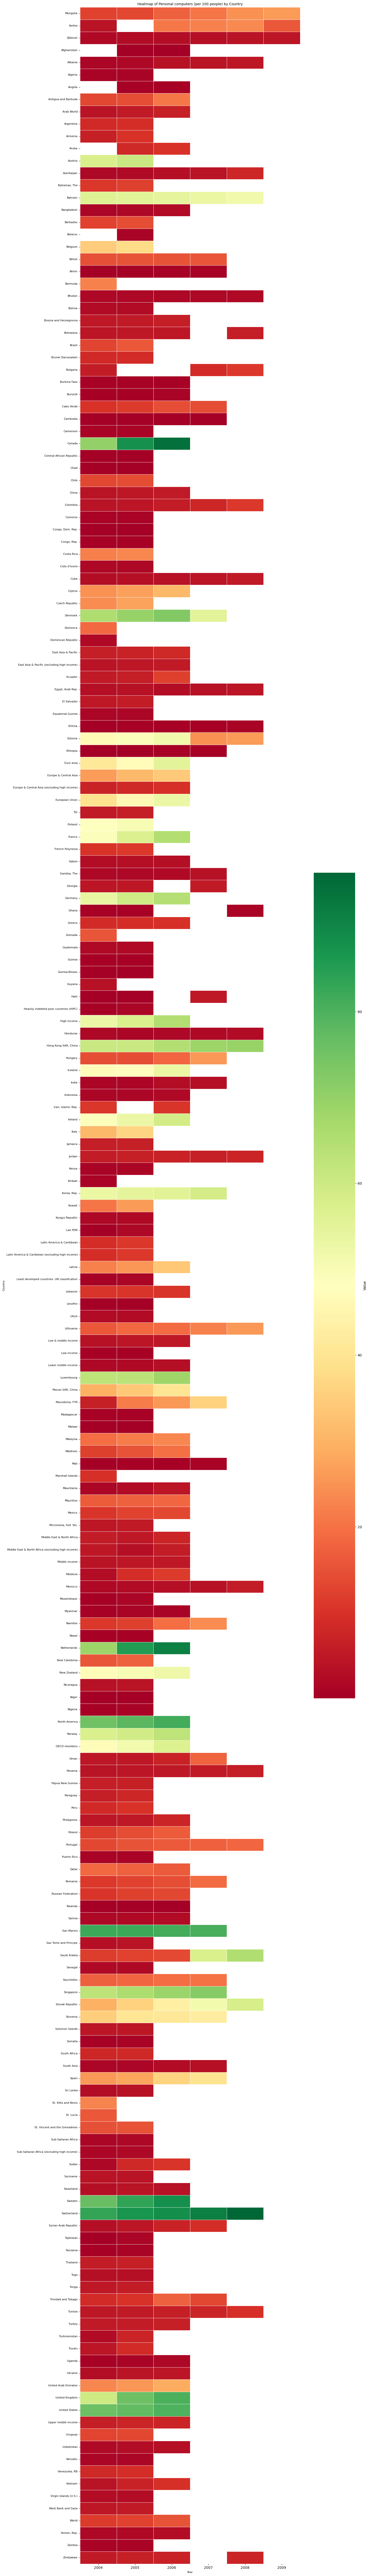

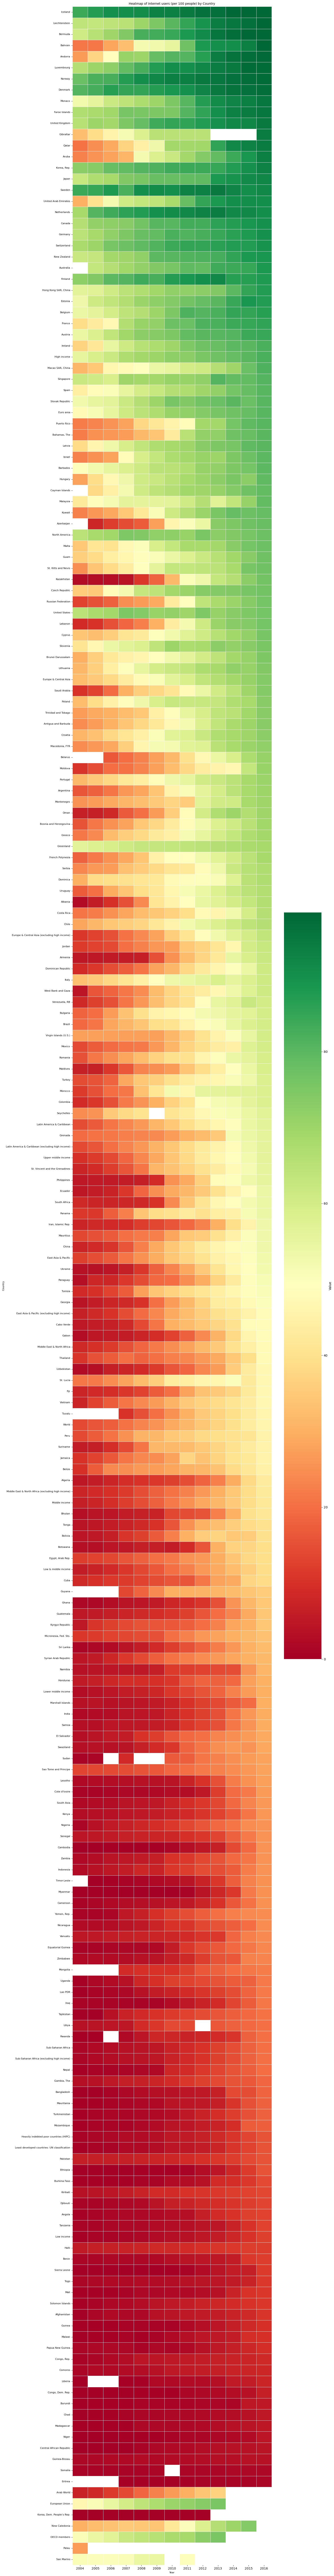

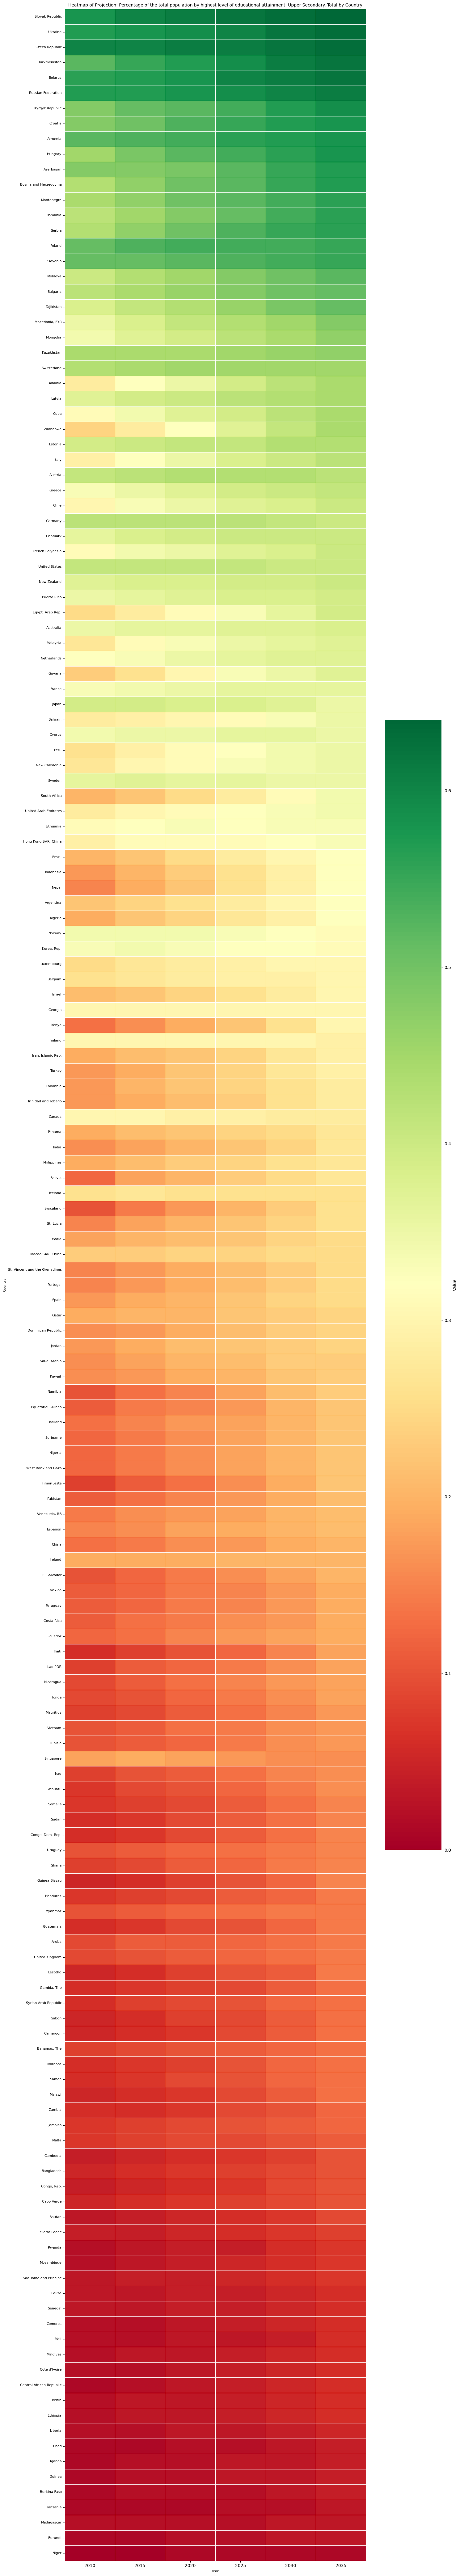

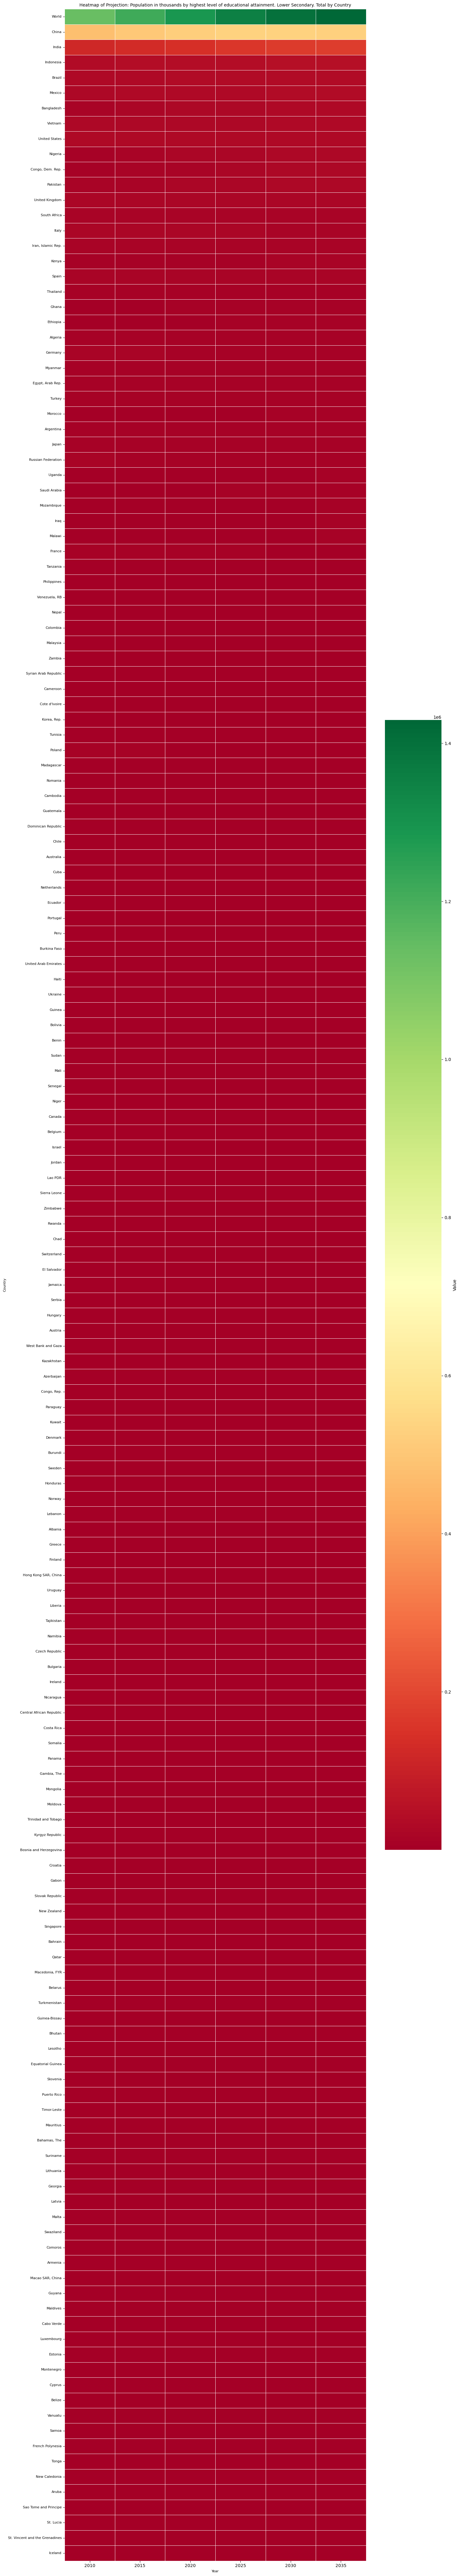

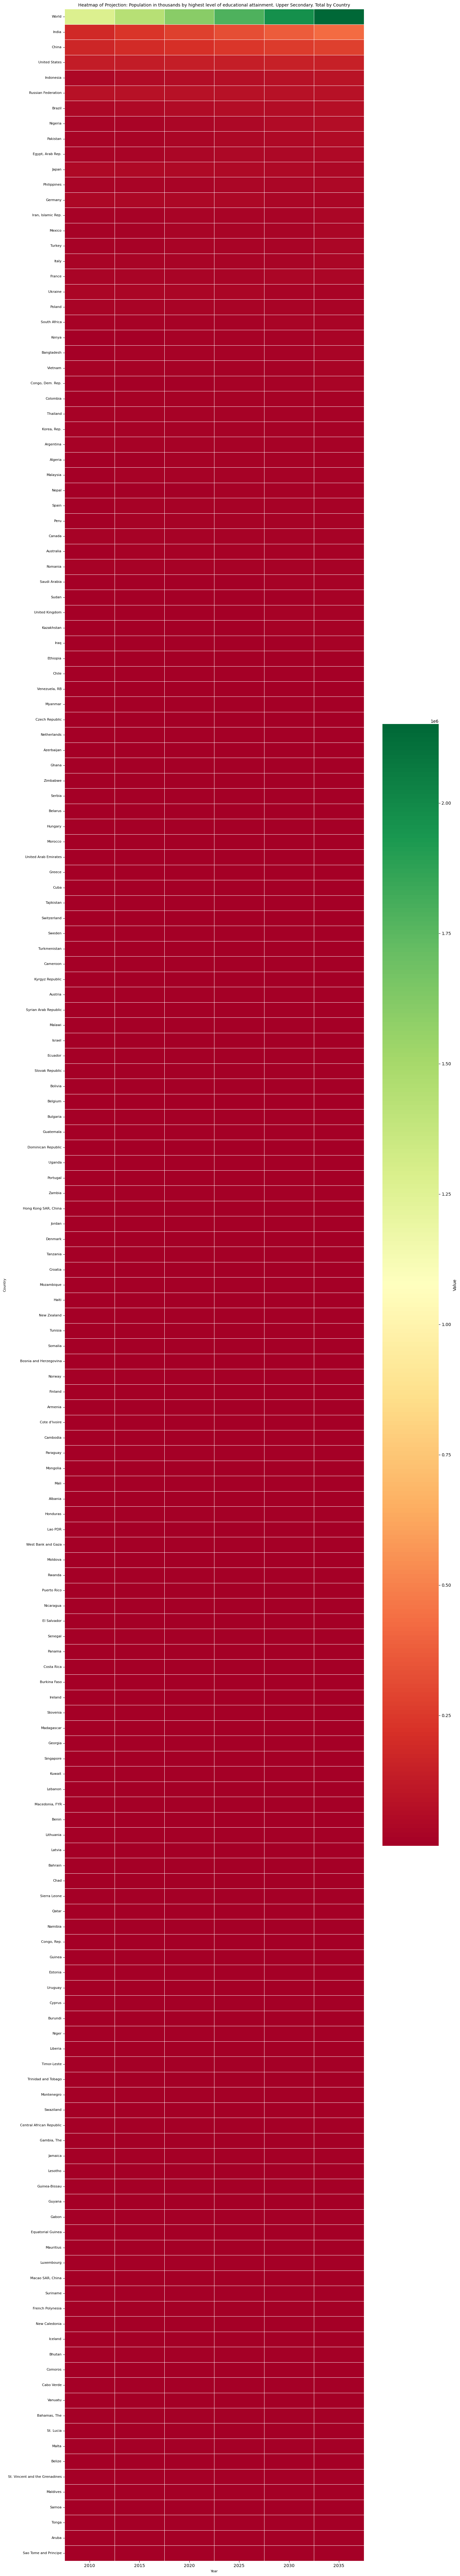

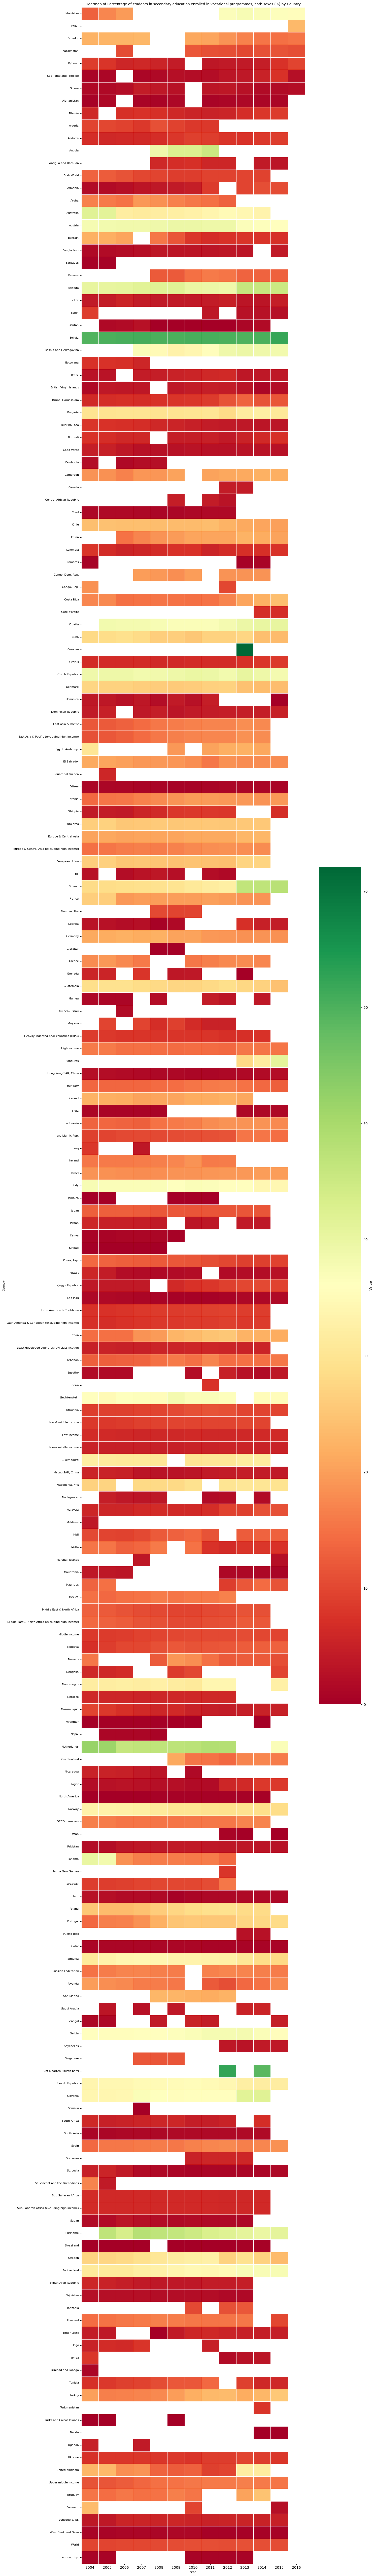

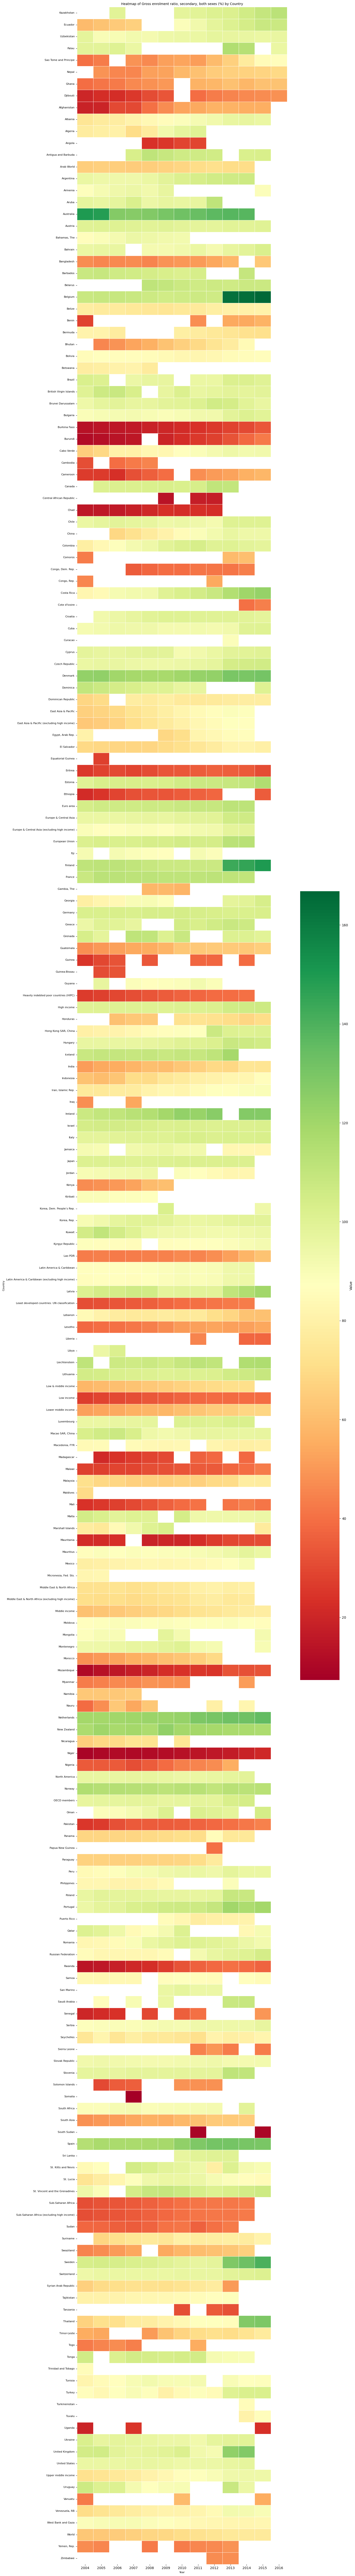

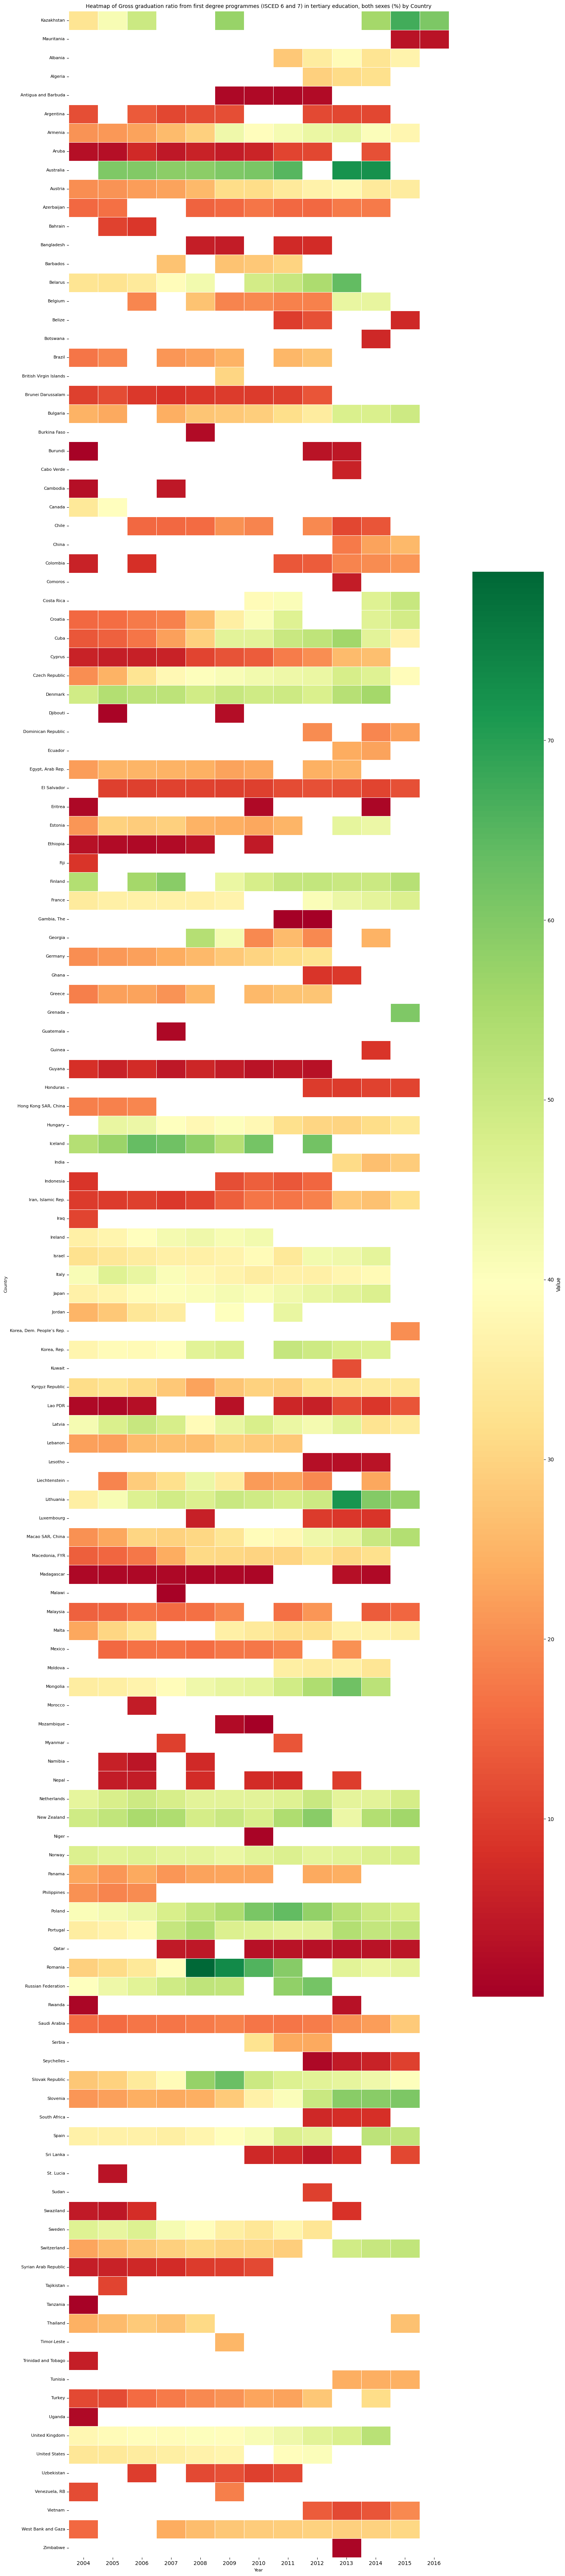

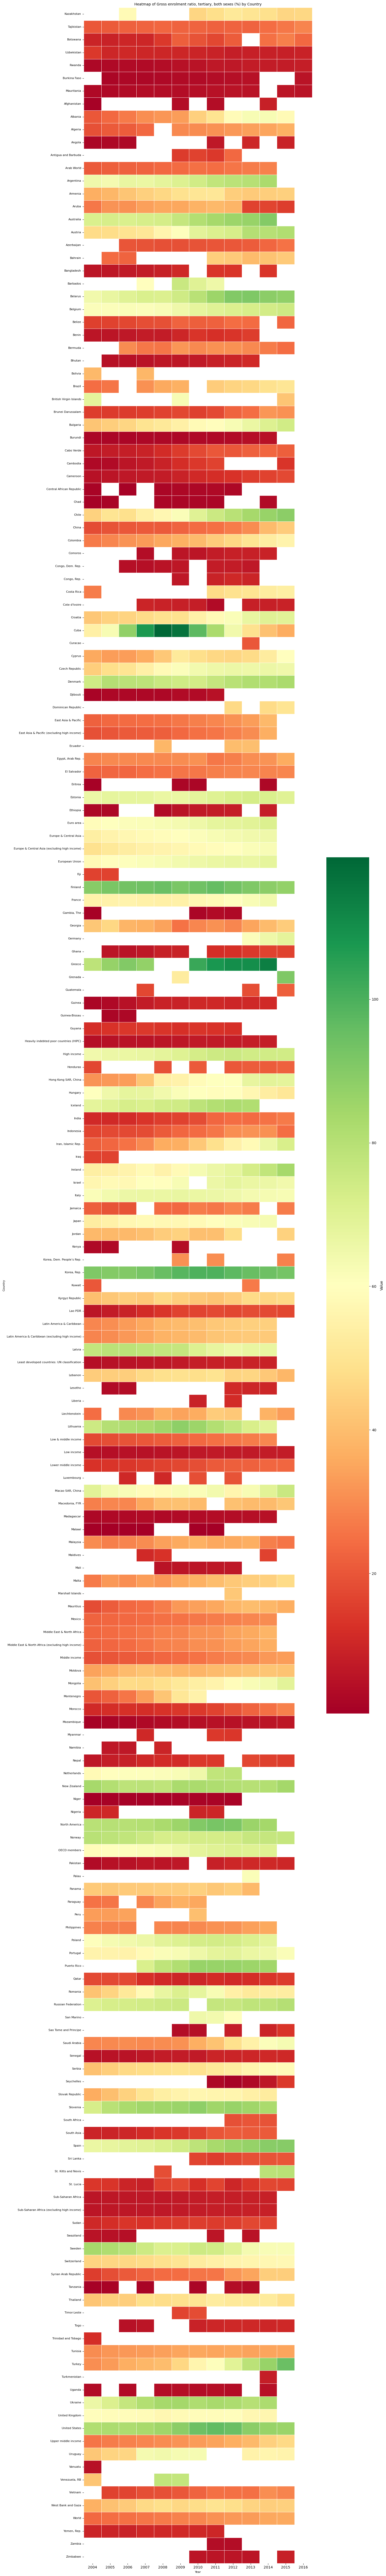

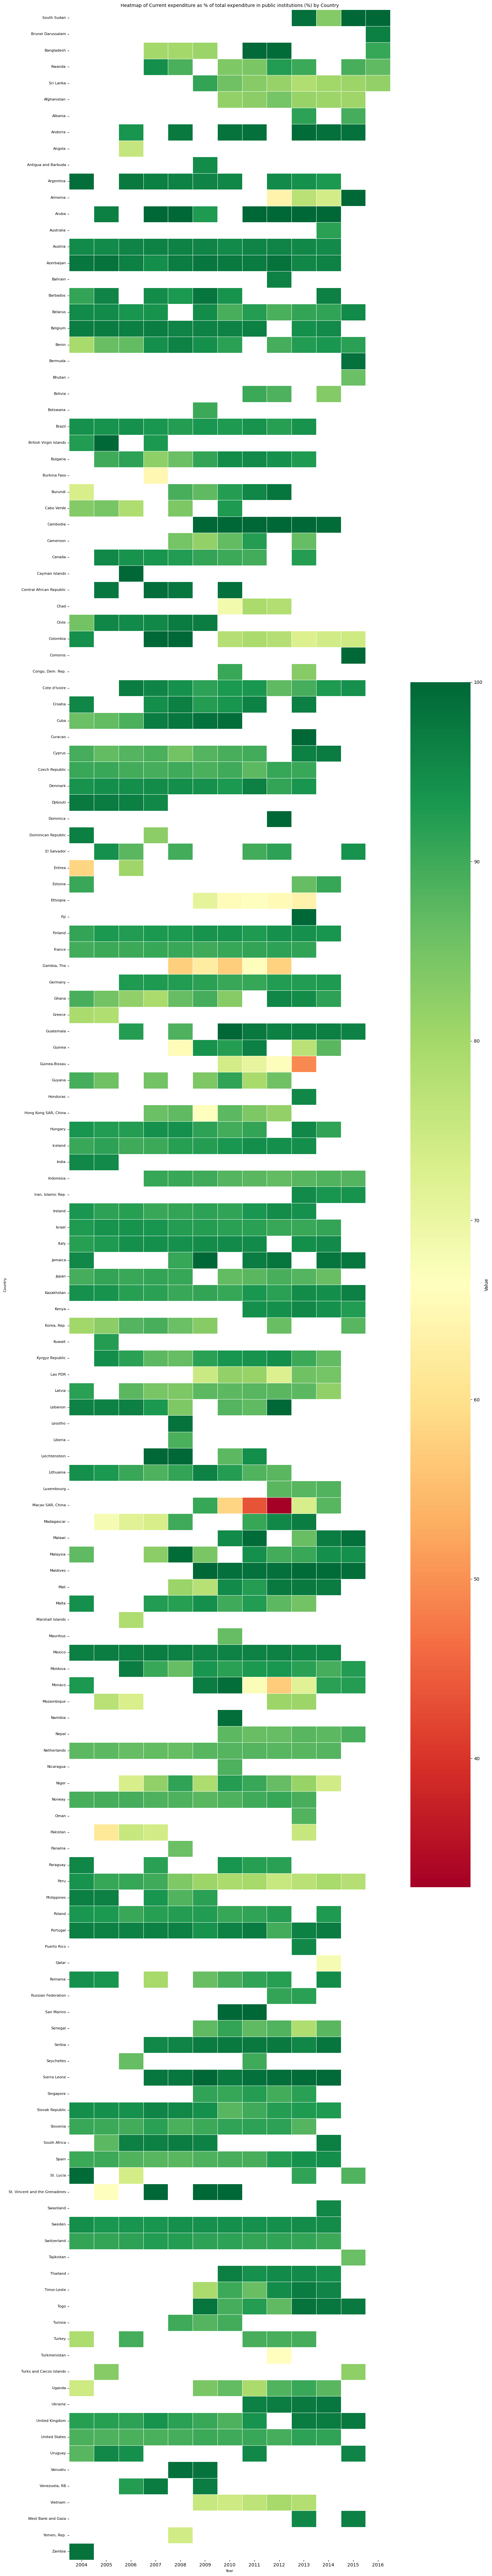

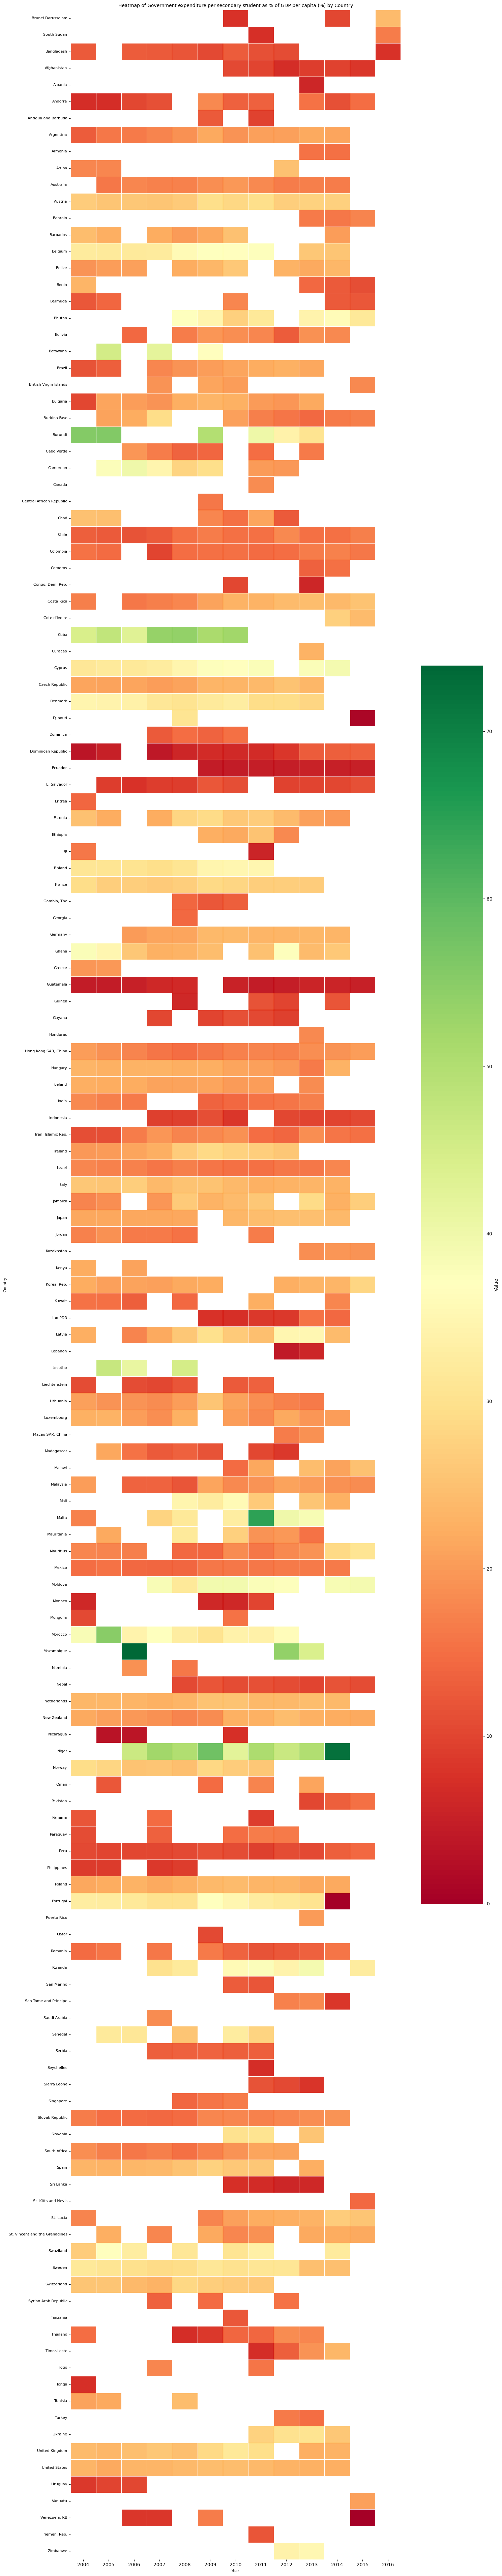

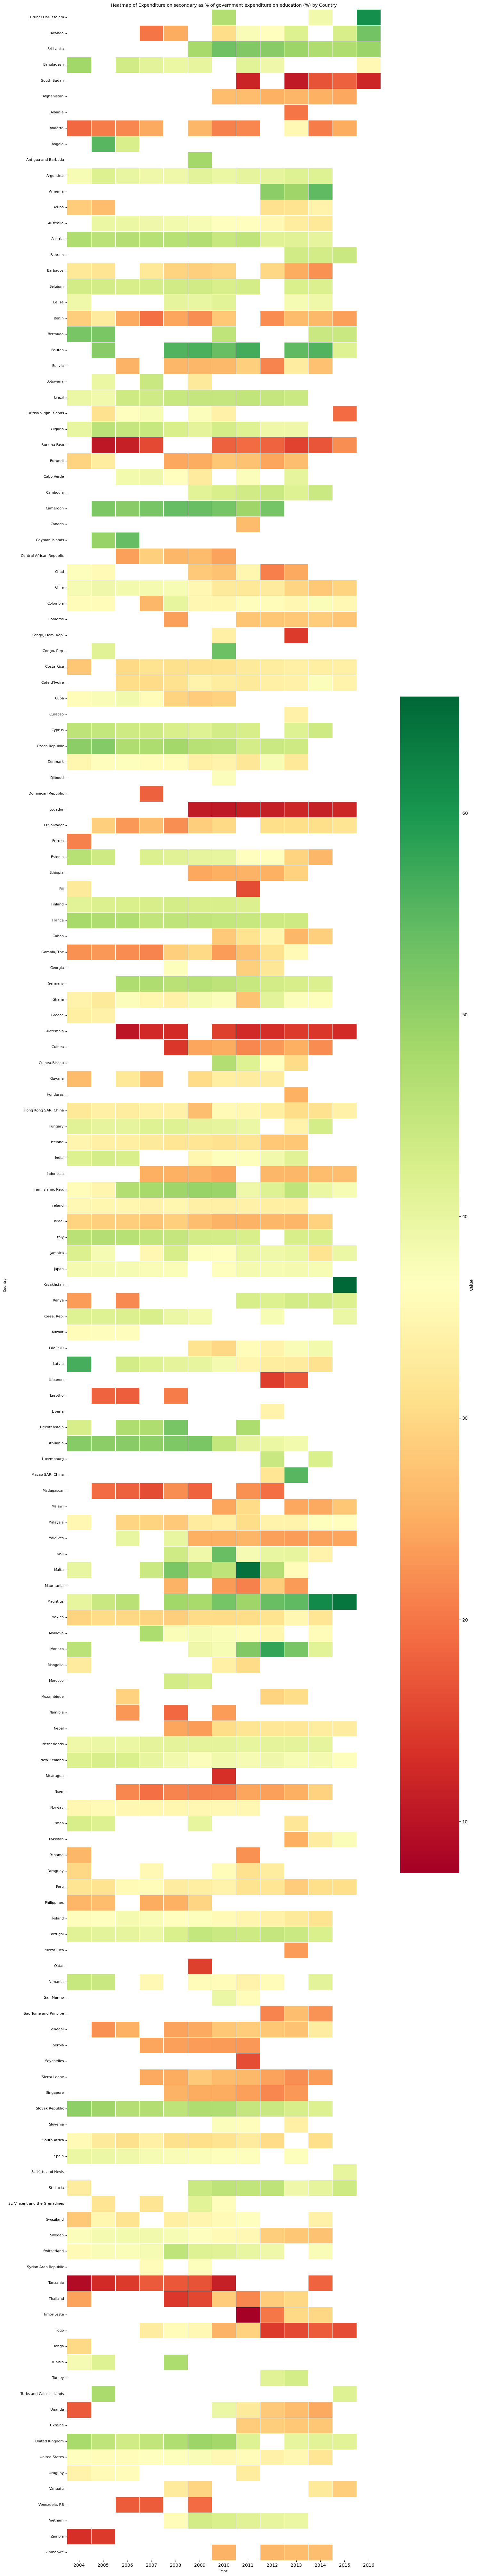

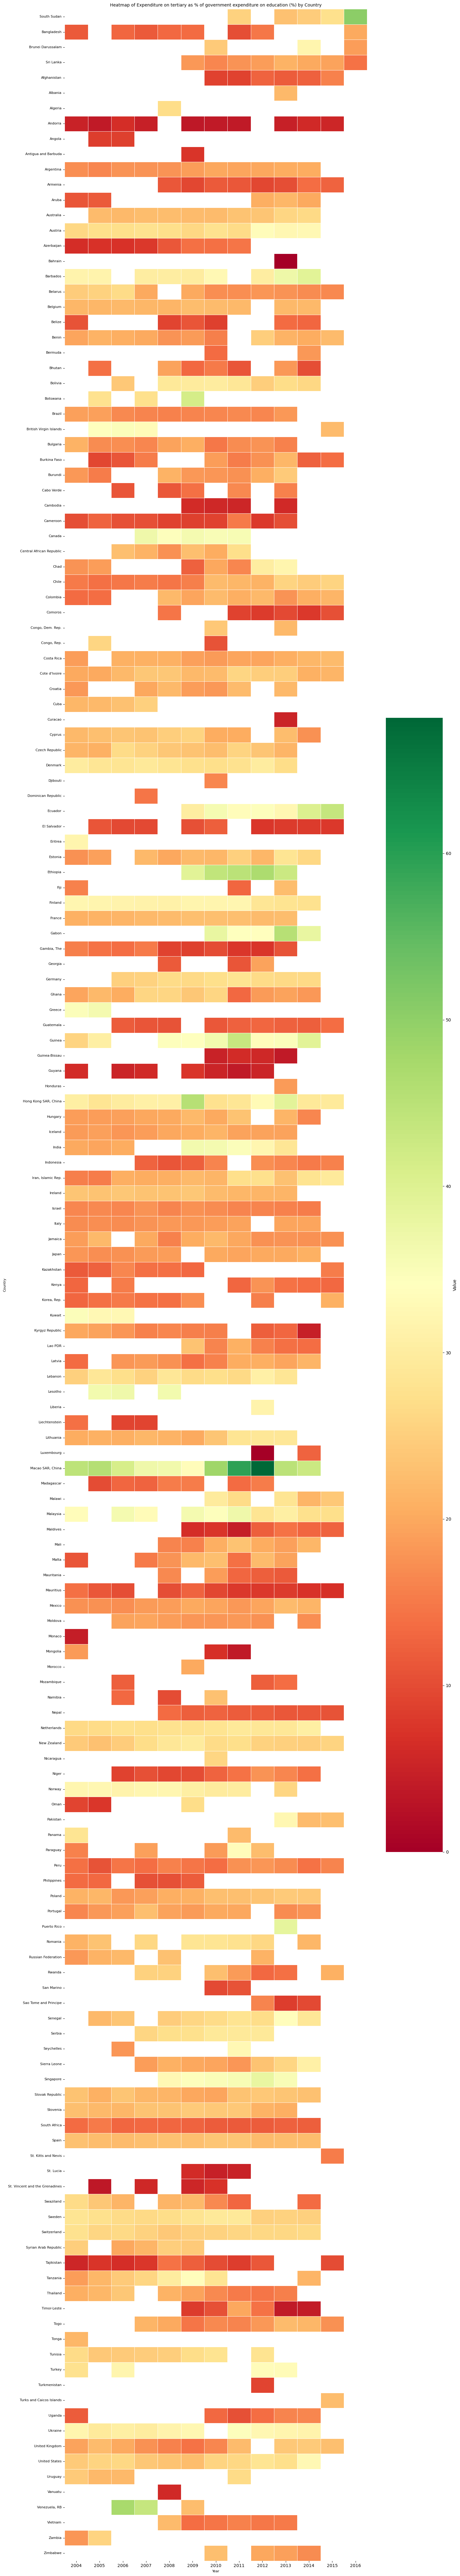

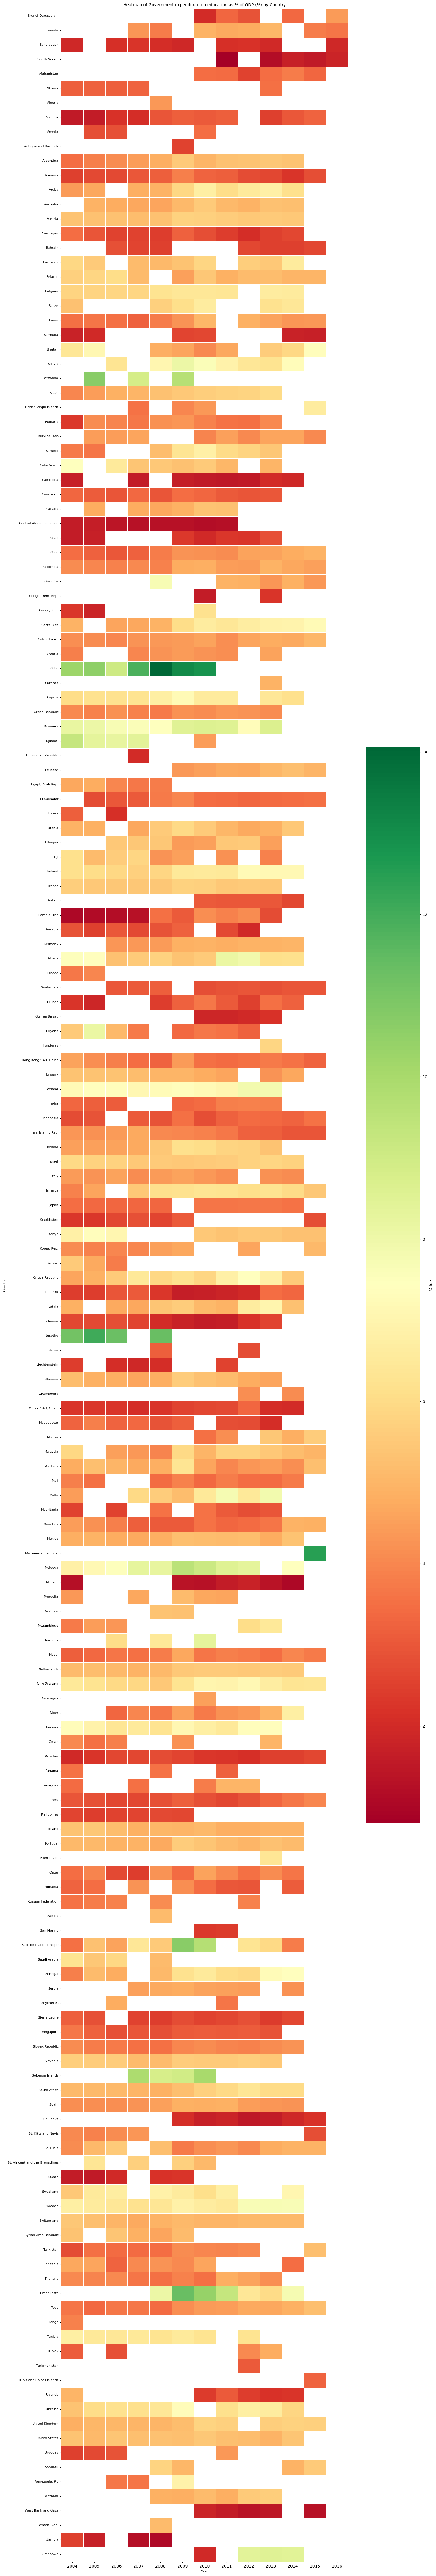

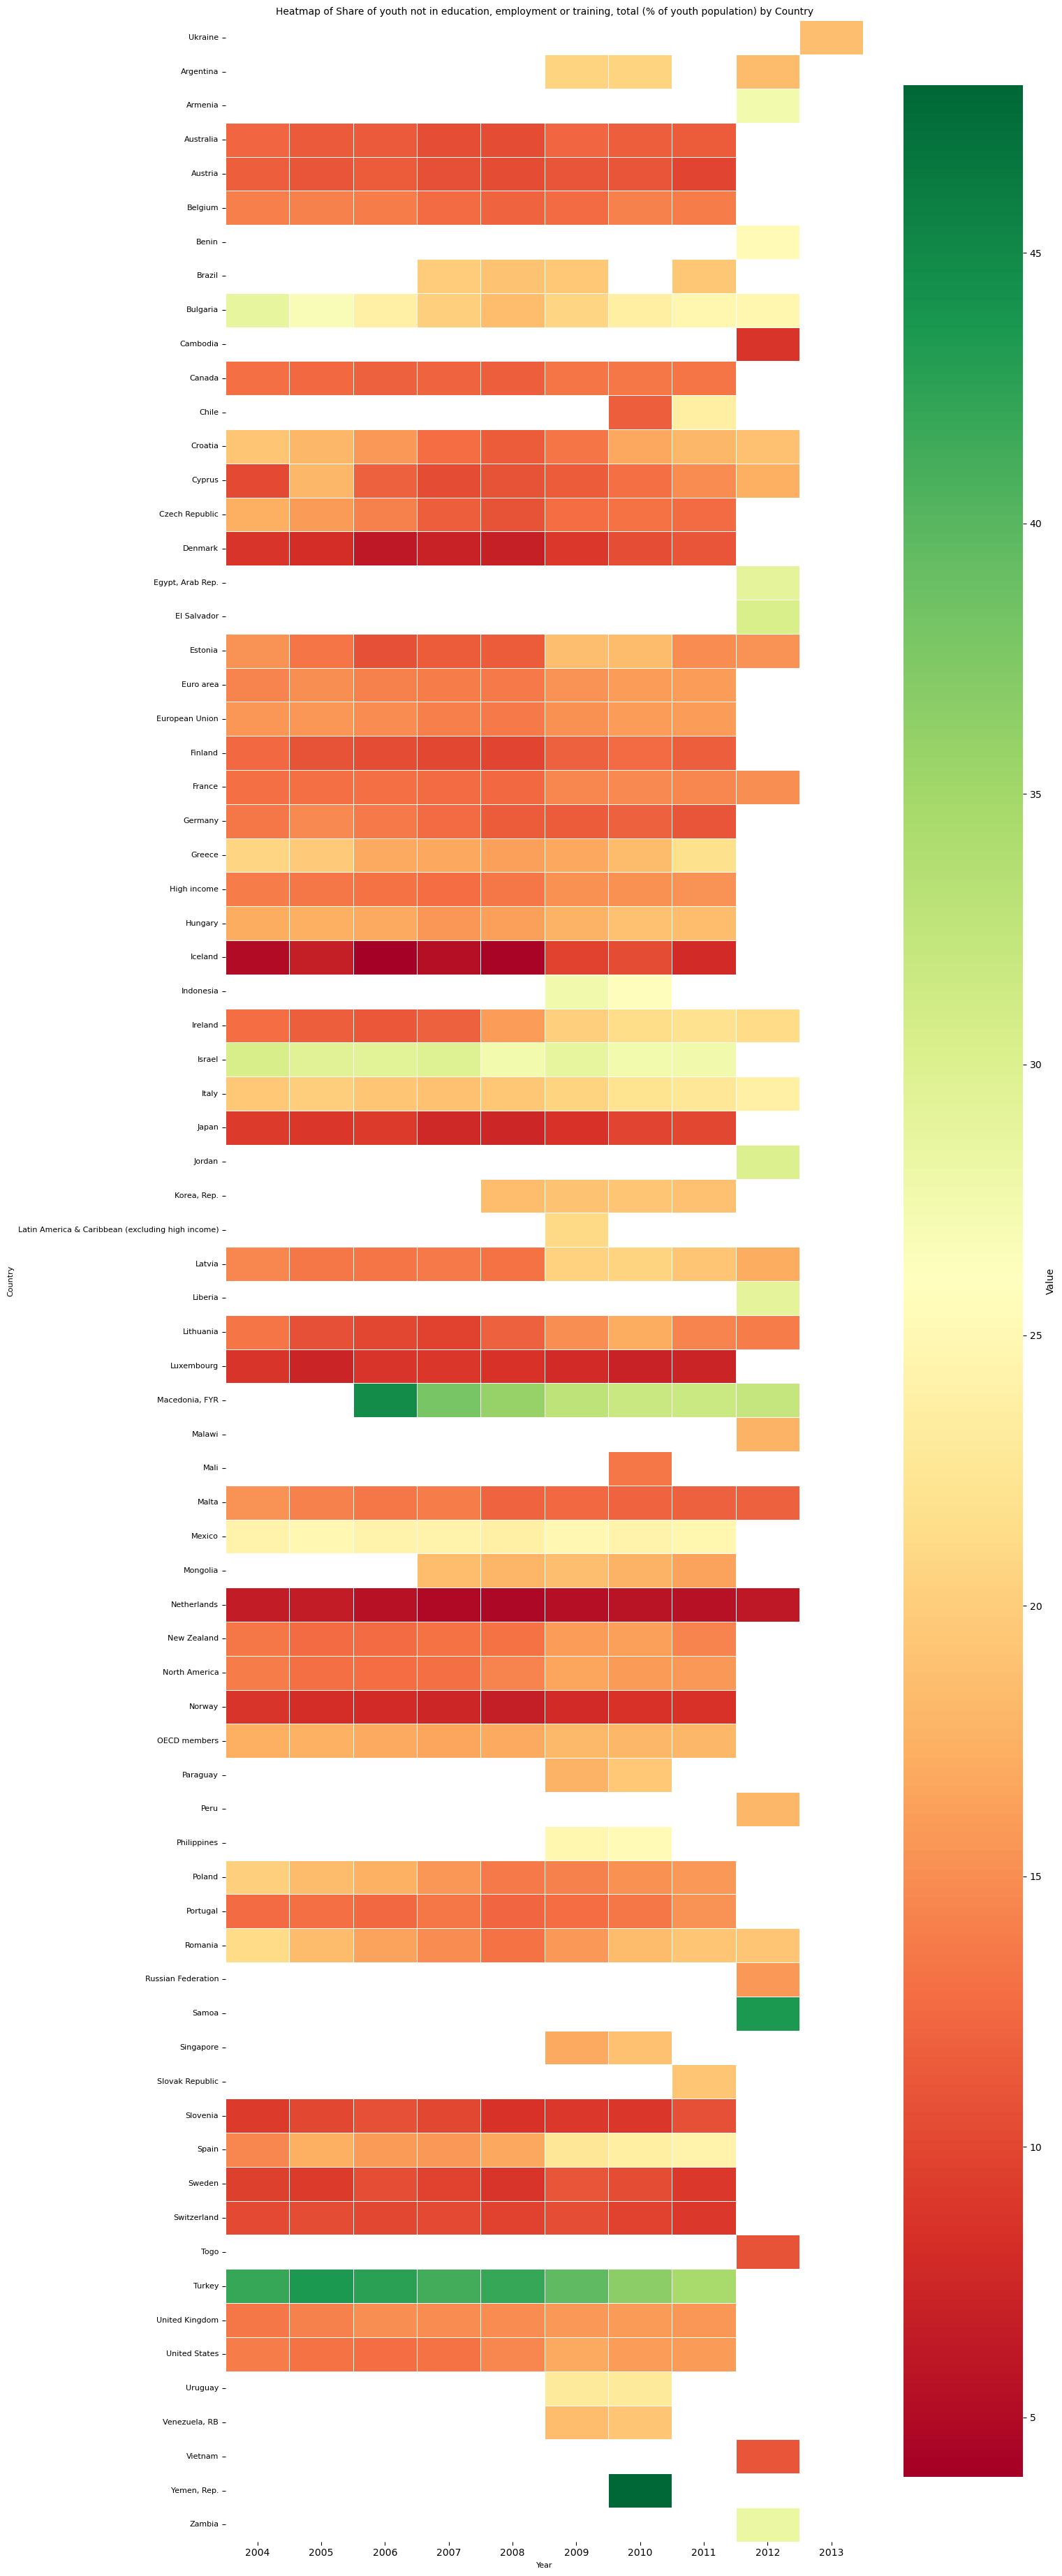

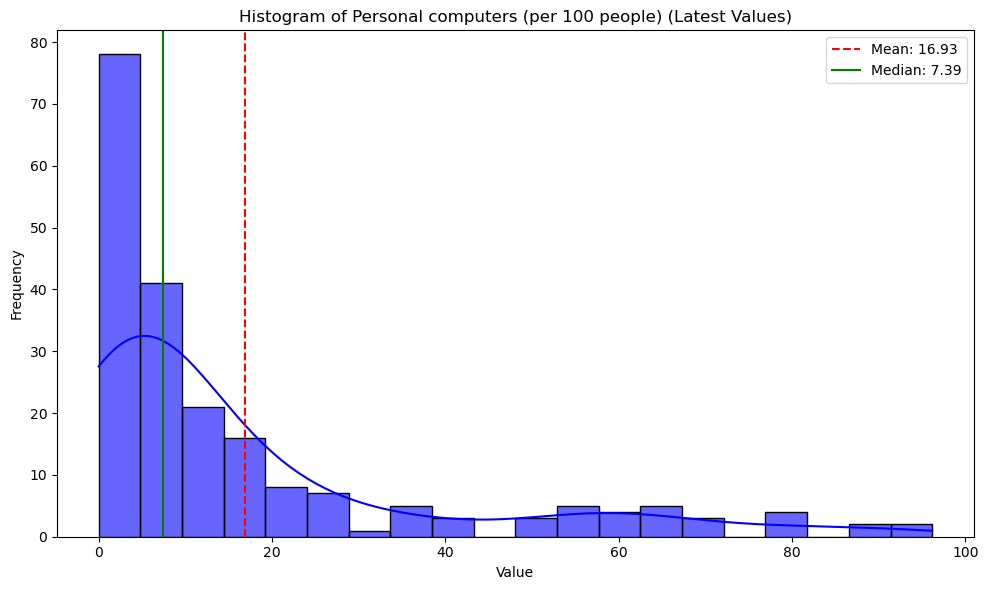

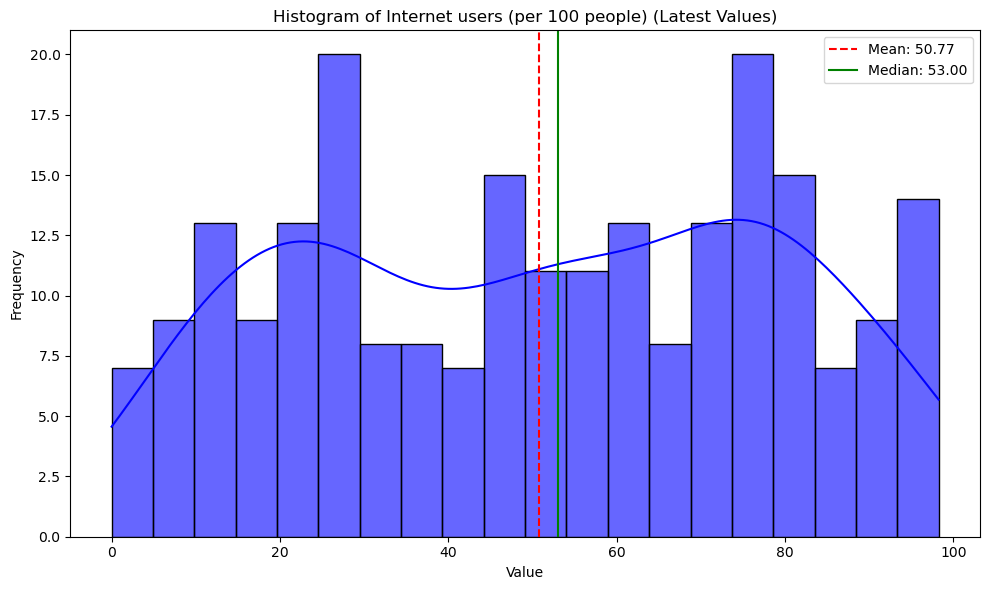

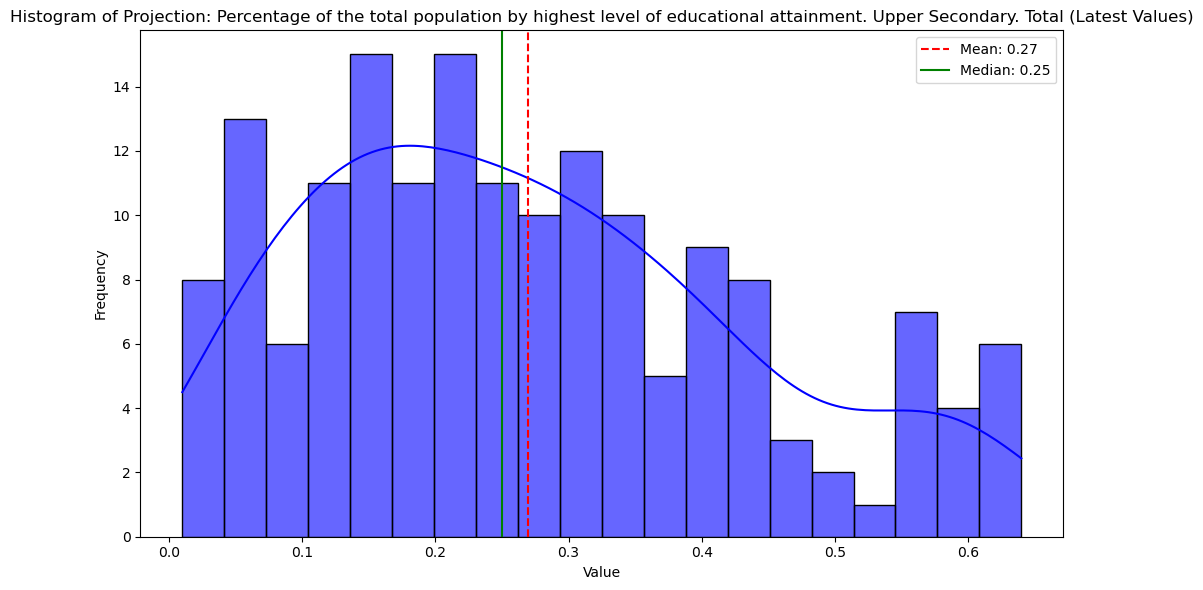

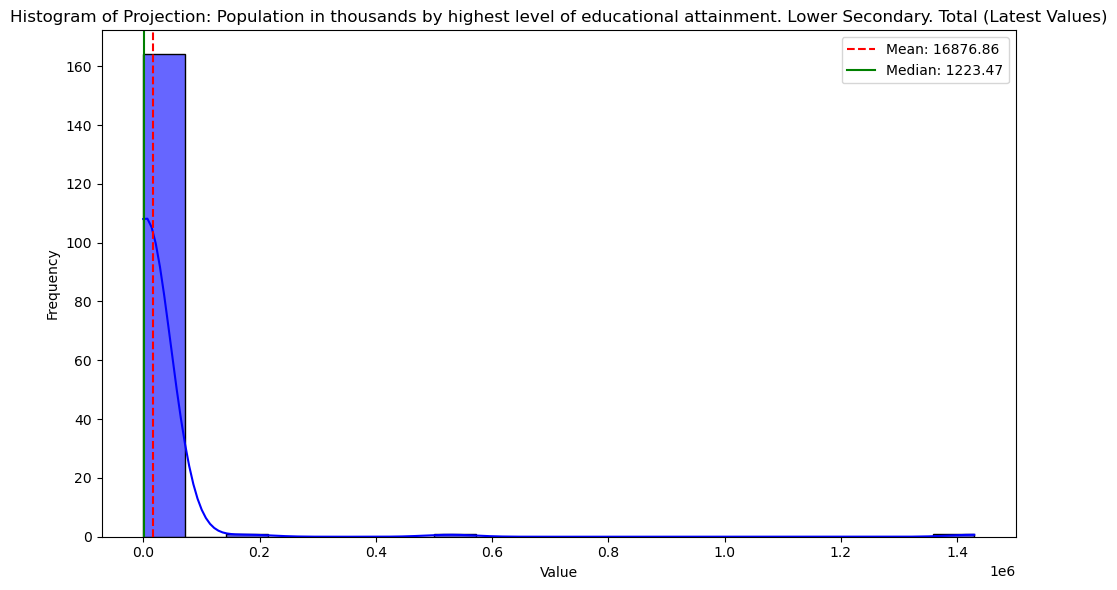

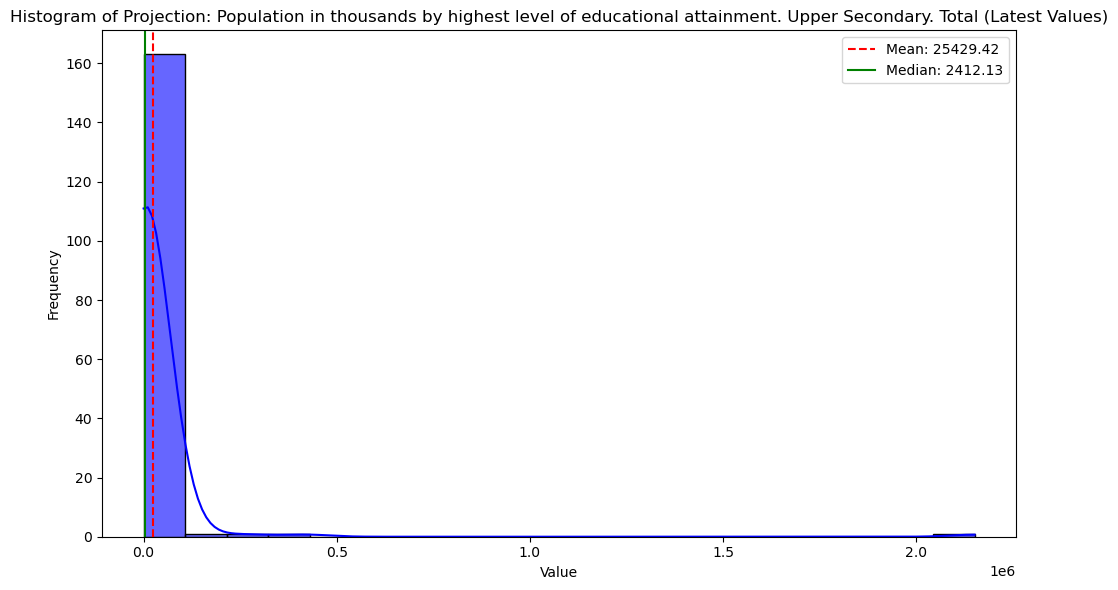

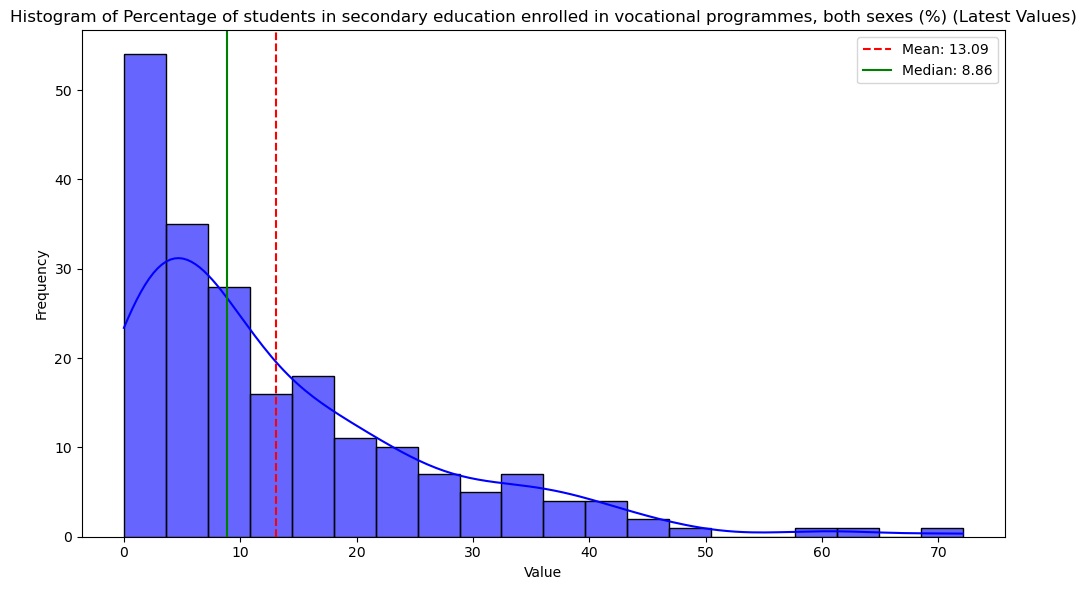

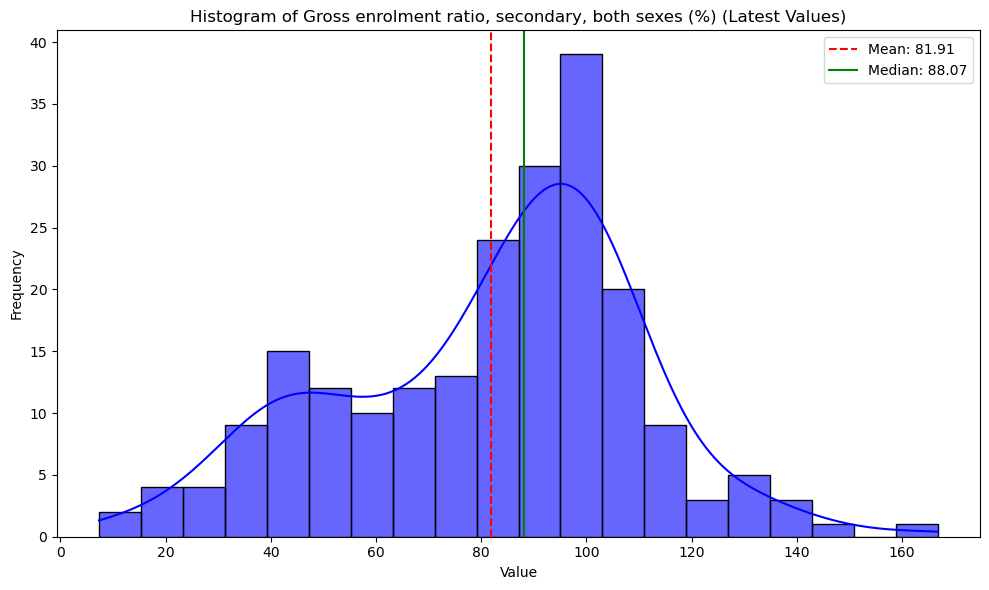

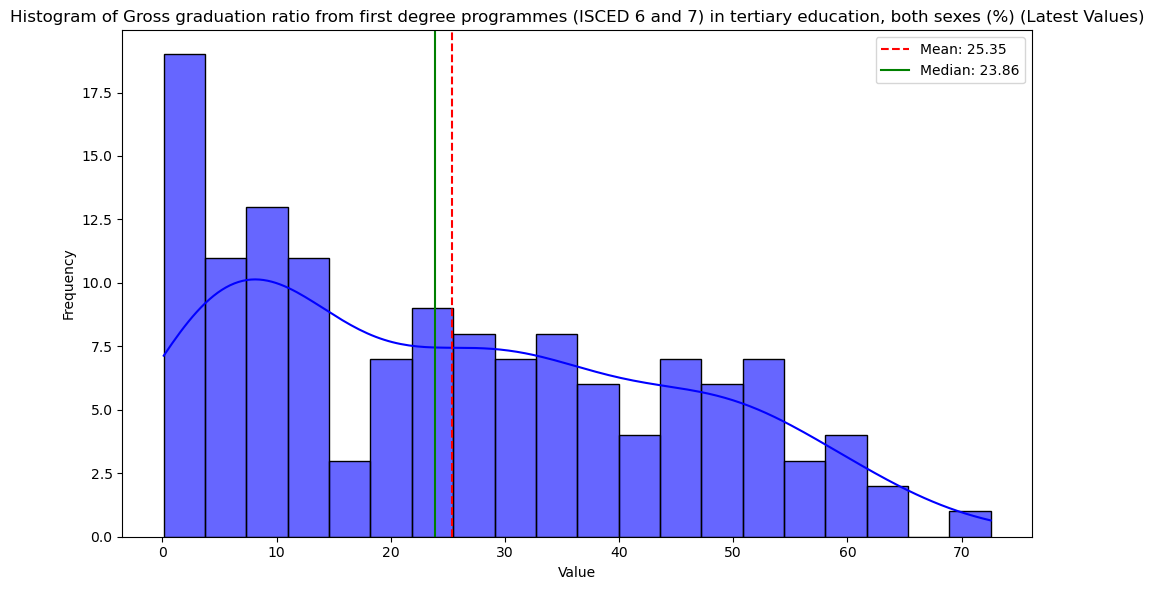

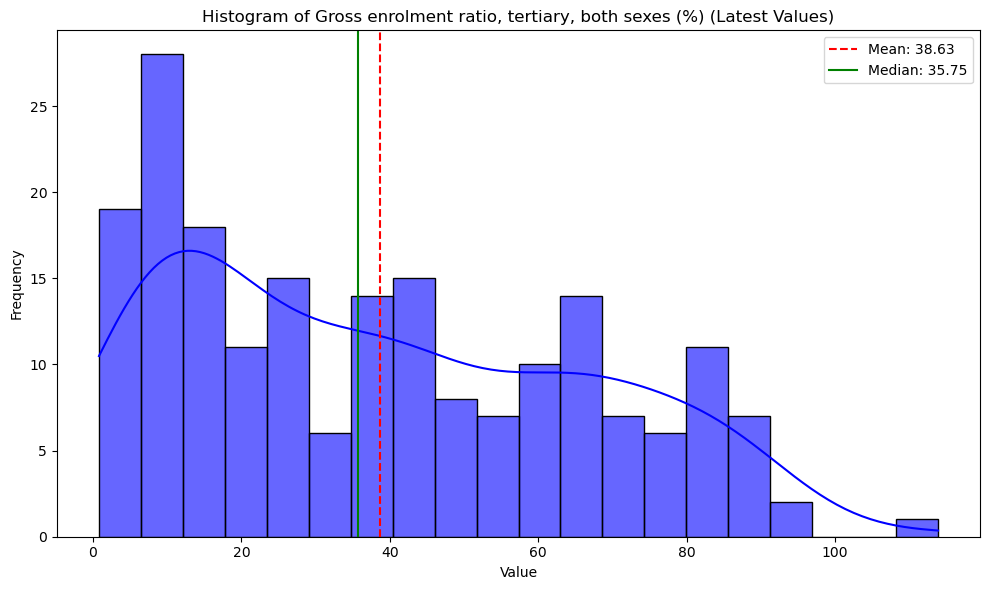

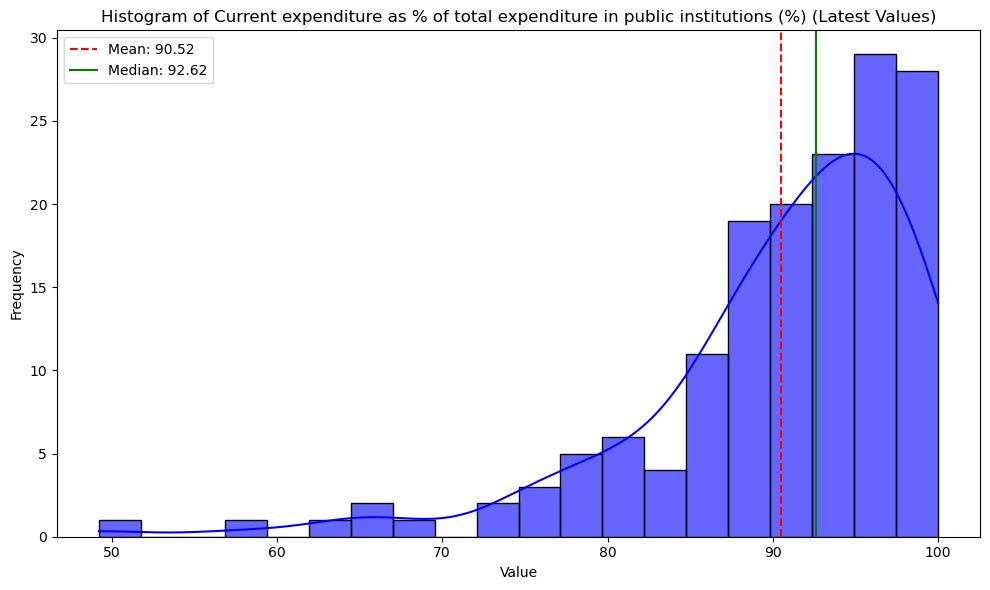

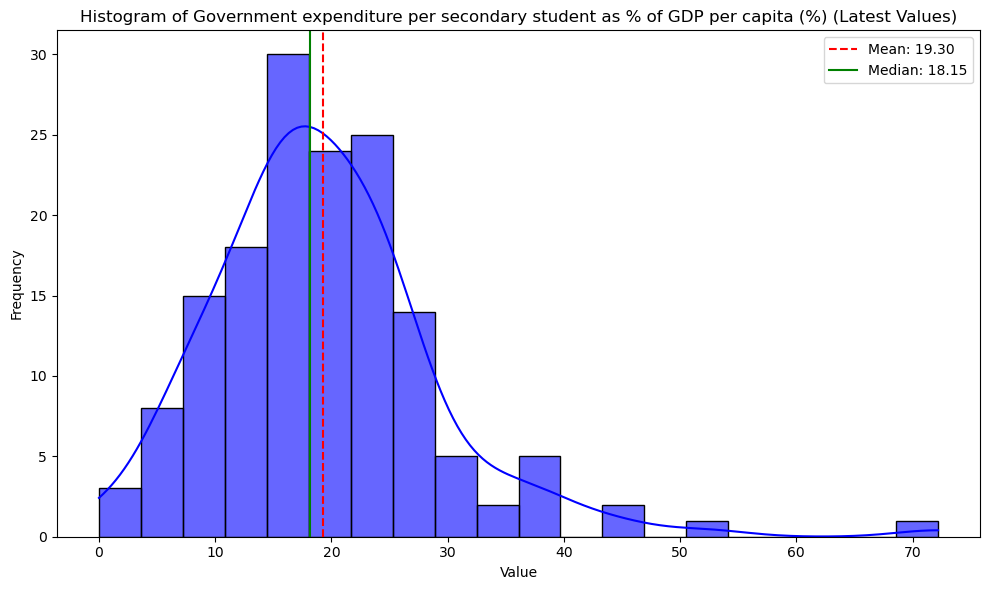

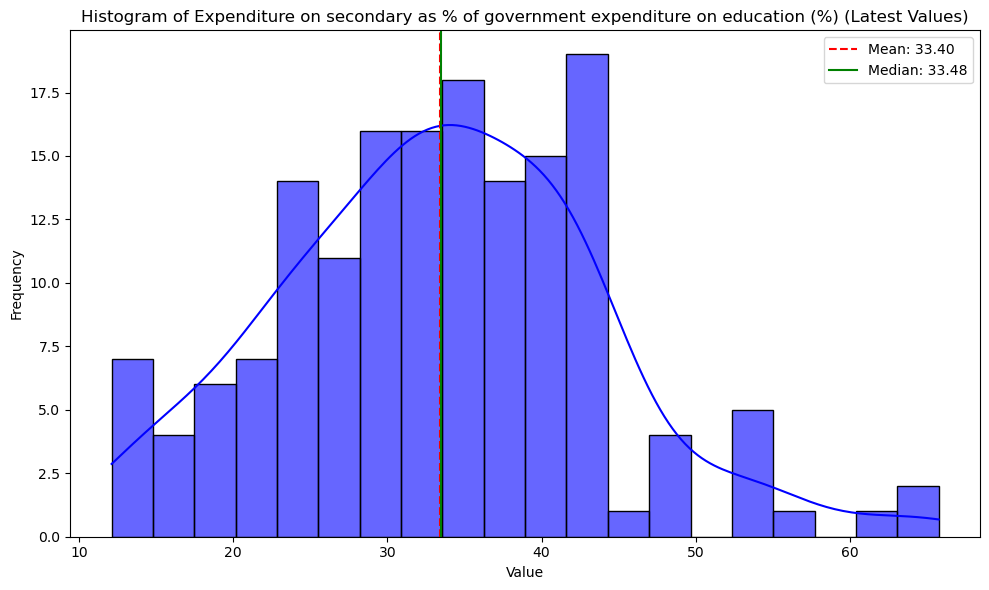

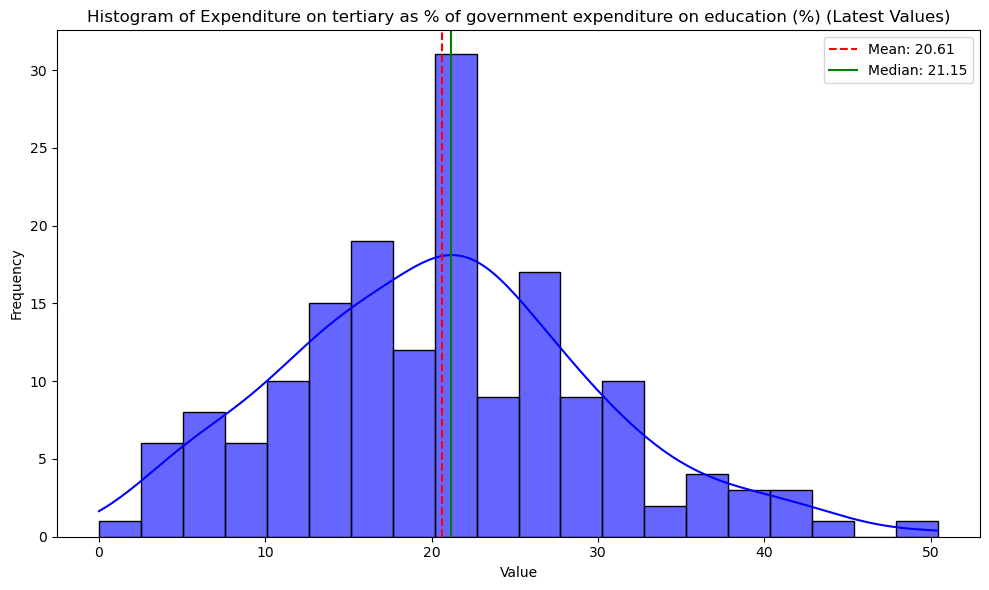

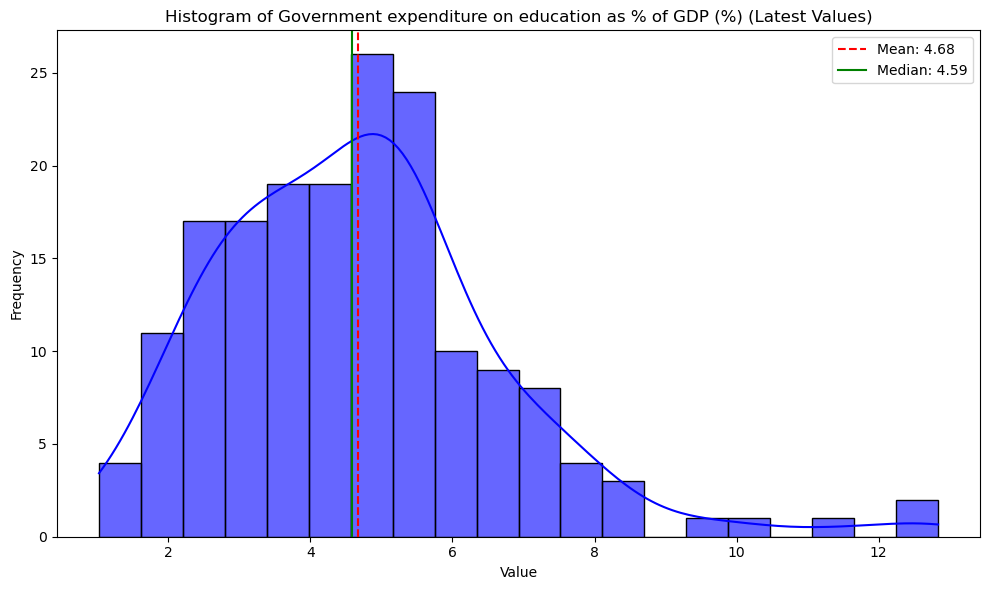

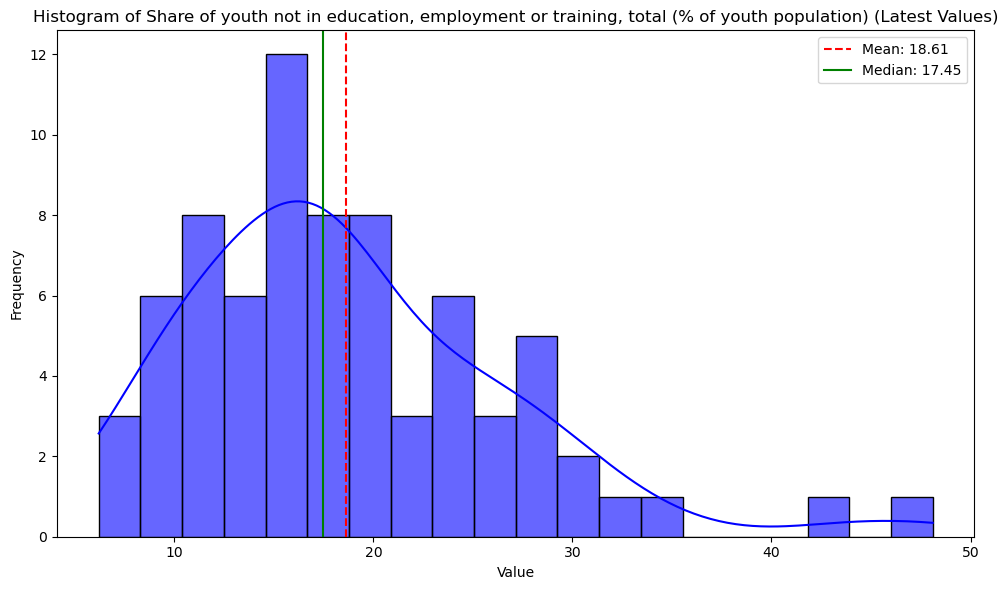

All indicators have data.


In [13]:
# Extract the latest values and identify indicators with no data
combined_latest_values, indicators_no_data = extract_latest_values(EdStatsData_reduced, EdStatsSeries_reduced, year_columns)

# Generate individual heatmaps
generate_individual_heatmaps(EdStatsData_reduced, EdStatsSeries_reduced, year_columns, combined_latest_values)

# Draw histograms with mean and median lines for each indicator and get the statistics
statistics_df = draw_histograms_with_mean_median(combined_latest_values, EdStatsSeries_reduced)

# Save the statistics to a CSV file
statistics_df.to_csv('data/graph/statistics_summary.csv', index=False)

# Save and print indicators with no data
if indicators_no_data:
    no_data_df = EdStatsSeries_reduced[EdStatsSeries_reduced['Series Code'].isin(indicators_no_data)]
    no_data_df = no_data_df[['Indicator Name', 'Series Code']]
    no_data_df.to_csv('data/graph/indicators_no_data.csv', index=False)
    print("Indicators with no data have been saved to 'data/graph/indicators_no_data.csv'.")
    print("Indicators with no data:")
    print(no_data_df)
else:
    print("All indicators have data.")

In [14]:
# Function to calculate scores based on a priority list
def calculate_scores(combined_data, priority_list):
    score = combined_data[priority_list].sum(axis=1)
    combined_data['Score'] = score
    combined_data.sort_values('Score', ascending=False, inplace=True)
    return combined_data



# Function to create a styled table with colored cells based on values
def create_styled_table(combined_data):
    combined_data = combined_data.apply(pd.to_numeric, errors='coerce')
    combined_data.sort_index(inplace=True)
    
    def color_cells(val):
        if pd.isnull(val):
            return f'background-color: rgba(255, 255, 128, .5)'
        color = sns.color_palette("RdYlGn", as_cmap=True)(val / combined_data.max().max())
        return f'background-color: rgba({color[0]*255}, {color[1]*0}, {color[2]*255}, 0.7)'

    styled_table = combined_data.style.map(lambda x: '').background_gradient(cmap='RdYlGn').format(lambda x: '' if pd.isnull(x) else '')

    # Modify headers to include slashes
    styled_table.set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'th.col_heading', 'props': [('white-space', 'nowrap'), ('border-bottom', '1px solid black')]}
    ])
    styled_table.set_table_attributes('style="border-collapse:collapse; border:1px solid black"')
    styled_table.set_properties(**{'text-align': 'center'})

    # Save the styled table to an HTML file
    styled_table.to_html('data/graph/consolidated_latest_value_table.html')

In [15]:
# Define priority list for KPIs
# priority_list = ['IT.CMP.PCMP.P2', 'IT.NET.USER.P2', 'SE.SEC.ENRL.VO.ZS']

# Calculate scores and sort combined data
# combined_latest_values = calculate_scores(combined_latest_values, priority_list)



# Create the styled table
create_styled_table(combined_latest_values)